# WIP Notebook

# Imports

In [4]:
import warnings

import branca.colormap as cm
import datetime
import folium
import glob
import holidays
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, mode, pearsonr, skew
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from skrub import GapEncoder, TableVectorizer
import xgboost as xgb
from ydata_profiling import ProfileReport
import requests
import zipfile
import io
import re

In [5]:
# Import provided data
train = pd.read_parquet("/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/data/train.parquet")
test = pd.read_parquet("/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/data/final_test.parquet")

In [209]:
# Import additionally sourced data

# https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/
weather = pd.read_csv(
    "/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/H_75_previous-2020-2022.csv.gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})


# https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/information/
# URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e6bcf4c994951fc086e31db6819a3448/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e35b9ec0a183a8f2c7a8537dd43b124c/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rf-202\d/202\d_S\d+_NB_FER\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(f, sep="\t", parse_dates=["JOUR"], dayfirst=True)
                    dfs.append(df)

# Combine all DataFrames
underground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


# https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/information/
# URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/41adcbd4216382c232ced4ccbf60187e/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/68cac32e8717f476905a60006a4dca26/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rs-202\d/202\d_T\d+_NB_SURFACE\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(
                        f,
                        sep="\t",
                        parse_dates=["JOUR"],
                        dayfirst=True,
                        encoding="latin1",
                    )
                    dfs.append(df)

# Combine all DataFrames
overground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

construction_sites_2020 = pd.read_parquet(
    "/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/chantiers-a-paris-2020.parquet"
)

construction_sites_2020['date_debut'] = pd.to_datetime(
    construction_sites_2020['date_debut'], format="%Y-%m-%d"
)
construction_sites_2020['date_fin'] = pd.to_datetime(
    construction_sites_2020['date_fin'], format="%Y-%m-%d"
)


  num_emprise cp_arrondissement  date_debut    date_fin  \
0    EC184638             75020  2020-09-21  2020-10-20   
1    EC184663             75009  2020-09-14  2020-10-09   
2    EC184760             75005  2020-09-07  2020-11-06   
3    EC184790             75012  2020-10-12  2020-11-13   
4    EC184837             75004  2020-10-19  2020-10-28   

                                  chantier_categorie  \
0    Opérateurs de réseau (gaz-électricité-RATP-etc)   
1  Ville de Paris (Tvx sur espace ou édifice public)   
2                       Tiers (travaux sur bâtiment)   
3    Opérateurs de réseau (gaz-électricité-RATP-etc)   
4                       Tiers (travaux sur bâtiment)   

                                     moa_principal  surface  \
0                                           ORANGE    49.39   
1       Direction de la Voirie et des Déplacements    18.49   
2  Propriétés - Co-propriétés publiques et privées     9.49   
3                                           ENEDIS     3

In [7]:
# # https://opendata.paris.fr/explore/dataset/chantiers-a-paris-copie0/information/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
# construction_sites_2020 = pd.read_parquet(
#     "/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/chantiers-a-paris-2020.parquet"
# )

# # https://opendata.paris.fr/explore/embed/dataset/chantiers-a-paris-copie1/table/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
# construction_sites_2021 = pd.read_parquet(
#     "/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/chantiers-a-paris-2021.parquet"
# )


# Add metro and bus stations
# Add high pedestrian traffic areas
# Add bike lanes, parks, etc.

In [8]:
def date_encoder(X, col="date"):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X["year"] = X[col].dt.year
    X["quarter"] = X[col].dt.quarter
    X["month"] = X[col].dt.month
    X["day"] = X[col].dt.day
    X["weekday"] = X[col].dt.weekday + 1
    X["hour"] = X[col].dt.hour

    # Binary variable indicating weekend or not (1=weekend, 0=weekday)
    X["is_weekend"] = (X["weekday"] > 5).astype(int)

    # Binary variable indicating bank holiday or not (1=holiday, 0=not holiday)
    import holidays

    fr_bank_holidays = holidays.FR()  # Get list of FR holidays
    X["is_bank_holiday"] = X[col].apply(lambda x: 1 if x in fr_bank_holidays else 0)

    X = X.copy()  # modify a copy of X

    # Binary variable indicating school holiday or not (1=holiday, 0=not holiday)
    # https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/
    fr_school_holidays = pd.read_csv(
        "/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/vacances_scolaires_france.csv"
    )[["date", "vacances_zone_c"]]

    # Ensure both DataFrames have a consistent datetime format
    X["date_normalized"] = pd.to_datetime(X[col]).dt.normalize()
    fr_school_holidays["date"] = pd.to_datetime(
        fr_school_holidays["date"]
    ).dt.normalize()

    # Create a dictionary from the holidays dataset for faster lookup
    holiday_mapping = dict(
        zip(fr_school_holidays["date"], fr_school_holidays["vacances_zone_c"])
    )

    # Map the normalized date to the holiday column
    X["is_school_holiday"] = (
        X["date_normalized"].map(holiday_mapping).fillna(0).astype(int)
    )

    # Drop the normalized date column if not needed
    X.drop(columns=["date_normalized"], inplace=True)

    # Finally, return the updated DataFrame
    return X

In [211]:
date_encoder(construction_sites_2020, col="date_debut")

,num_emprise,cp_arrondissement,date_debut,date_fin,chantier_categorie,moa_principal,surface,chantier_synthese,localisation_detail,localisation_stationnement,...,geo_point_2d,year,quarter,month,day,weekday,hour,is_weekend,is_bank_holiday,is_school_holiday
0,EC184638,75020,2020-09-21,2020-10-20,Opérateurs de réseau (gaz-électricité-RATP-etc),ORANGE,49.39,Travaux sur réseau télécom,EMPRISE_TROTTOIR,None,...,b'\x01\x01\x00\x00\x00\x15\x83.\xeb\x14-\x03@\...,2020,3,9,21,1,0,0,0,0
1,EC184663,75009,2020-09-14,2020-10-09,Ville de Paris (Tvx sur espace ou édifice public),Direction de la Voirie et des Déplacements,18.49,Aménagement de voirie (VdP*),EMPRISE_CHAUSSEE,None,...,b'\x01\x01\x00\x00\x00\x04\xac\xe2\xd36\xa3\x0...,2020,3,9,14,1,0,0,0,0
2,EC184760,75005,2020-09-07,2020-11-06,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,9.49,Construction ou réhabilitation d'immeuble,EMPRISE_CHAUSSEE,STATIONNEMENT_PAYANT,...,b'\x01\x01\x00\x00\x00se\x15\xf1\xeb\xd0\x02@\...,2020,3,9,7,1,0,0,0,0
3,EC184790,75012,2020-10-12,2020-11-13,Opérateurs de réseau (gaz-électricité-RATP-etc),ENEDIS,3.09,Travaux sur réseau électrique,EMPRISE_TROTTOIR,None,...,b'\x01\x01\x00\x00\x00x\x82\x9e\x14\x96\x05\x0...,2020,4,10,12,1,0,0,0,0
4,EC184837,75004,2020-10-19,2020-10-28,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,4.45,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,...,b'\x01\x01\x00\x00\x00\r\xaaf\x0f\xfb\xe1\x02@...,2020,4,10,19,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22880,EC128785,75007,2019-09-30,2020-05-26,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,22.83,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,...,b'\x01\x01\x00\x00\x00U\xbd\x10\x9a\xfc\x88\x0...,2019,3,9,30,1,0,0,0,0
22881,EC128982,75017,2019-07-01,2020-01-20,Ville de Paris (Tvx sur espace ou édifice public),Direction de la Voirie et des Déplacements,16.52,Aménagement de voirie (VdP*),EMPRISE_CHAUSSEE,None,...,b'\x01\x01\x00\x00\x00\xf4\x83\xd1\x99\x9e\x99...,2019,3,7,1,1,0,0,0,0
22882,EC129068,75016,2019-08-19,2020-11-16,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,6.92,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,...,b'\x01\x01\x00\x00\x00\xde\xbc\x83\xf5\x7ff\x0...,2019,3,8,19,1,0,0,0,1
22883,EC129453,75007,2019-09-02,2020-06-24,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,5.40,Construction ou réhabilitation d'immeuble,"EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",STATIONNEMENT_PAYANT,...,b'\x01\x01\x00\x00\x00\x8e\xbcA\xdez\xa7\x02@i...,2019,3,9,2,1,0,0,0,0


# EDA

## Data Overview

### Provided data (train and test sets)

##### Basic exploration

In [9]:
train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [10]:
train.shape

(496827, 12)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [12]:
train.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

In [13]:
train["date"].min(), train["date"].max()

(Timestamp('2020-09-01 01:00:00'), Timestamp('2021-09-09 23:00:00'))

In [14]:
test.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [15]:
test.shape

(51440, 10)

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 51440 non-null  category      
 1   counter_name               51440 non-null  category      
 2   site_id                    51440 non-null  int64         
 3   site_name                  51440 non-null  category      
 4   date                       51440 non-null  datetime64[us]
 5   counter_installation_date  51440 non-null  datetime64[us]
 6   coordinates                51440 non-null  category      
 7   counter_technical_id       51440 non-null  category      
 8   latitude                   51440 non-null  float64       
 9   longitude                  51440 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(2), int64(1)
memory usage: 2.2 MB


In [17]:
test.nunique()

counter_id                    56
counter_name                  56
site_id                       30
site_name                     30
date                         933
counter_installation_date     22
coordinates                   30
counter_technical_id          30
latitude                      30
longitude                     30
dtype: int64

In [18]:
test["date"].min(), test["date"].max()

(Timestamp('2021-09-10 01:00:00'), Timestamp('2021-10-18 21:00:00'))

#### Train set exploration

##### Bike count by coordinates

In [19]:
# Calculate the total bike count per location
location_counts = (
    train.groupby(["latitude", "longitude"])["bike_count"].sum().reset_index()
)

# Create a colormap
colormap = cm.linear.PuRd_09.scale(
    location_counts["bike_count"].min(), location_counts["bike_count"].max()
)

# Create the map
m = folium.Map(
    location=train[["latitude", "longitude"]].mean(axis=0).values, zoom_start=13
)

# Add markers to the map
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=colormap(row["bike_count"]),
        fill=True,
        fill_color="black",  # Fill center with black
        fill_opacity=1,  # Ensure the fill is opaque
        popup=f"Bike Count: {row['bike_count']}",
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

m

It seems that the further away from the city center, the less bike passage there is. Let's try to find a smart way of creating a new feature that represents this.

In [20]:
(
    train.groupby("site_name", observed=True)["bike_count"]
    .sum()
    .sort_values(ascending=False)
).head()

site_name
Totem 73 boulevard de Sébastopol    3490139.0
Totem 64 Rue de Rivoli              2567605.0
Face au 48 quai de la marne         1718564.0
27 quai de la Tournelle             1613233.0
Quai d'Orsay                        1567932.0
Name: bike_count, dtype: float64

The counter with most bikes registered is: Totem 73 boulevard de Sébastopol. Let's use the coordinates from this site to create a distance feature (see Feature engineering).

##### Bike count by site_name (time series)

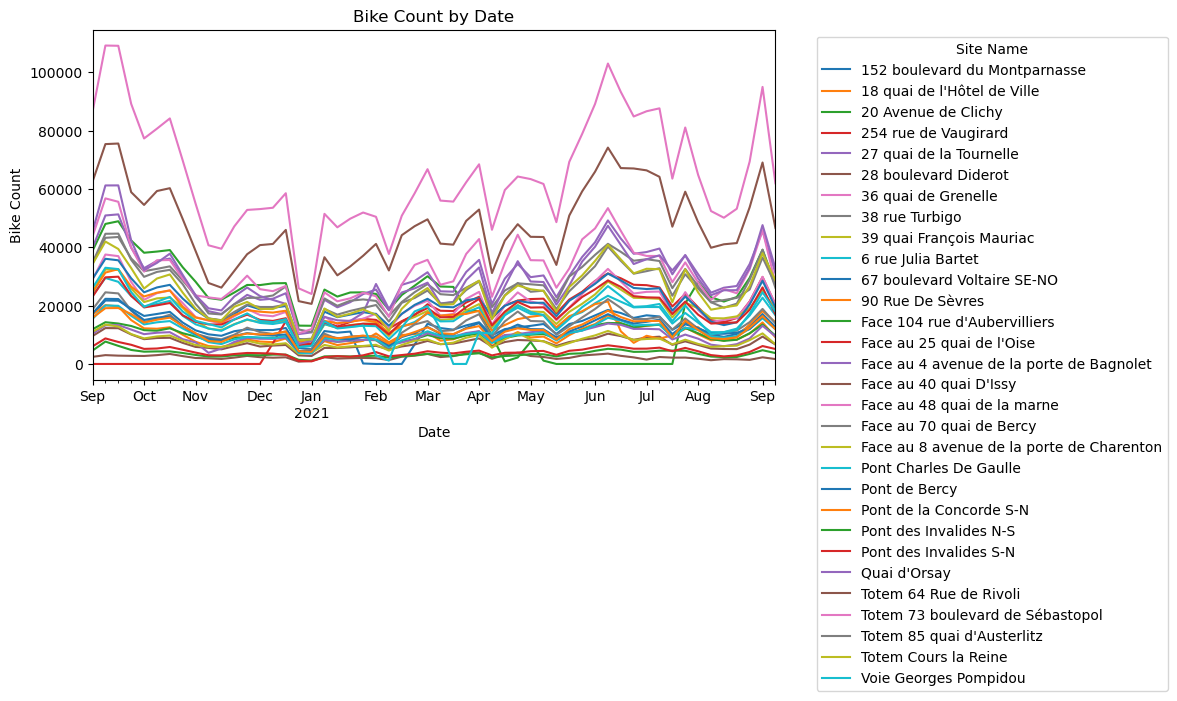

In [21]:
# Pivot the DataFrame so each counter name has its own column
pivot_df = (
    train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)[
        "bike_count"
    ]
    .sum()
    .unstack()
)

# Plot the data
pivot_df.plot(figsize=(12, 6))
plt.title("Bike Count by Date")
plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.legend(title="Site Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

##### Bike count by counter_name (boxplot)

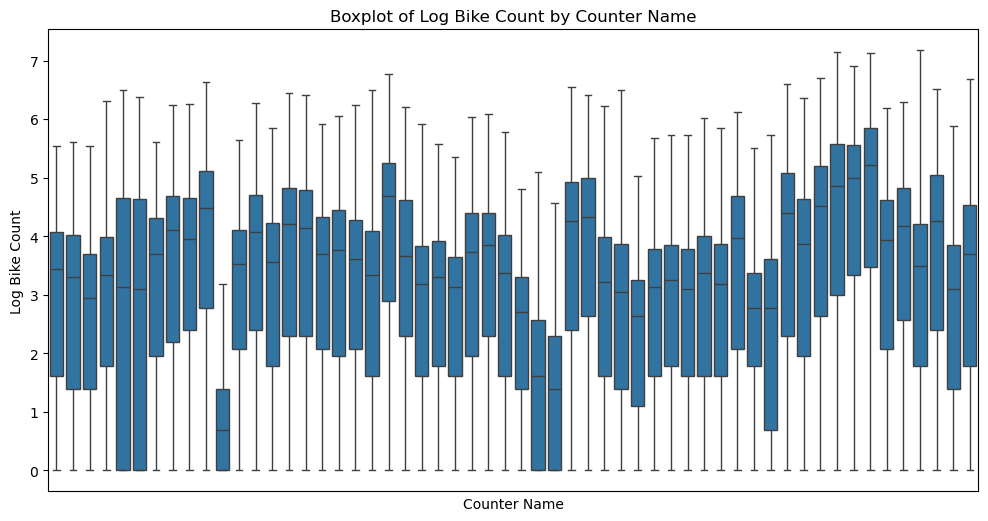

In [22]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="counter_name", y="log_bike_count", data=train)

# Add labels and title
plt.xlabel("Counter Name")
plt.ylabel("Log Bike Count")
plt.title("Boxplot of Log Bike Count by Counter Name")

# Hide the x-axis labels
plt.xticks([])

# Display the plot
plt.show()

In [23]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assuming your data is already loaded into a DataFrame named 'train'

# # Perform ANOVA
# model = ols('log_bike_count ~ C(site_name)', data=train).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

# # If ANOVA is significant, perform post-hoc analysis
# if anova_table['PR(>F)'].iloc[0] < 0.05:
#     tukey = pairwise_tukeyhsd(endog=train['log_bike_count'], groups=train['site_name'], alpha=0.05)
#     print(tukey)

# else:
#     print("ANOVA is not significant, no need for post-hoc analysis.")

##### Weekly bike count by site_name

In [24]:
train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)[
    "bike_count"
].sum().unstack()

site_name,152 boulevard du Montparnasse,18 quai de l'Hôtel de Ville,20 Avenue de Clichy,254 rue de Vaugirard,27 quai de la Tournelle,28 boulevard Diderot,36 quai de Grenelle,38 rue Turbigo,39 quai François Mauriac,6 rue Julia Bartet,...,Pont de Bercy,Pont de la Concorde S-N,Pont des Invalides N-S,Pont des Invalides S-N,Quai d'Orsay,Totem 64 Rue de Rivoli,Totem 73 boulevard de Sébastopol,Totem 85 quai d'Austerlitz,Totem Cours la Reine,Voie Georges Pompidou
date,,,,,,,,,,,,,,,,,,,,,
2020-09-06,16902.0,16949.0,38803.0,0.0,39748.0,9572.0,28939.0,34467.0,24648.0,23439.0,...,17276.0,15838.0,4595.0,6025.0,45437.0,62498.0,86444.0,34680.0,34209.0,26040.0
2020-09-13,21747.0,20168.0,48004.0,0.0,50907.0,12302.0,37516.0,43241.0,32397.0,29486.0,...,22330.0,19129.0,7677.0,8760.0,61196.0,75367.0,109156.0,44624.0,41960.0,32981.0
2020-09-20,21680.0,19715.0,48918.0,0.0,51277.0,12263.0,36962.0,43527.0,32247.0,28158.0,...,22262.0,19166.0,6206.0,7540.0,61213.0,75565.0,109069.0,44684.0,39417.0,32518.0
2020-09-27,19022.0,15031.0,42328.0,0.0,39875.0,10115.0,28095.0,36188.0,25884.0,23289.0,...,18420.0,17120.0,4803.0,6576.0,42319.0,58893.0,89158.0,35701.0,32874.0,24633.0
2020-10-04,16460.0,12214.0,38126.0,0.0,32840.0,8501.0,21993.0,31801.0,21217.0,19755.0,...,15070.0,14184.0,4215.0,5172.0,32221.0,54521.0,77298.0,29868.0,25860.0,19585.0
2020-10-11,17137.0,12076.0,38531.0,0.0,35326.0,8895.0,24264.0,32600.0,22492.0,20561.0,...,15891.0,15161.0,4301.0,5296.0,34650.0,59283.0,80661.0,31556.0,29292.0,21346.0
2020-10-18,17861.0,12578.0,39050.0,0.0,36143.0,8975.0,25212.0,33459.0,22792.0,21604.0,...,16145.0,15874.0,4311.0,5819.0,37807.0,60252.0,84167.0,32266.0,30680.0,22956.0
2020-10-25,14192.0,10016.0,33158.0,0.0,29804.0,7225.0,20873.0,28640.0,19286.0,16522.0,...,13038.0,12975.0,3764.0,4878.0,30541.0,49679.0,69739.0,27329.0,24459.0,17983.0
2020-11-01,11520.0,7609.0,28183.0,0.0,23024.0,5842.0,16093.0,23501.0,14861.0,13595.0,...,10304.0,10553.0,3086.0,3903.0,23563.0,38720.0,54942.0,20587.0,18931.0,14750.0


It seems like some sites are not capturing any data at all at times (multiple weeks sometimes). We will need to investigate this further.

Let's take a specific site that did not capture bikes for multiple weeks.

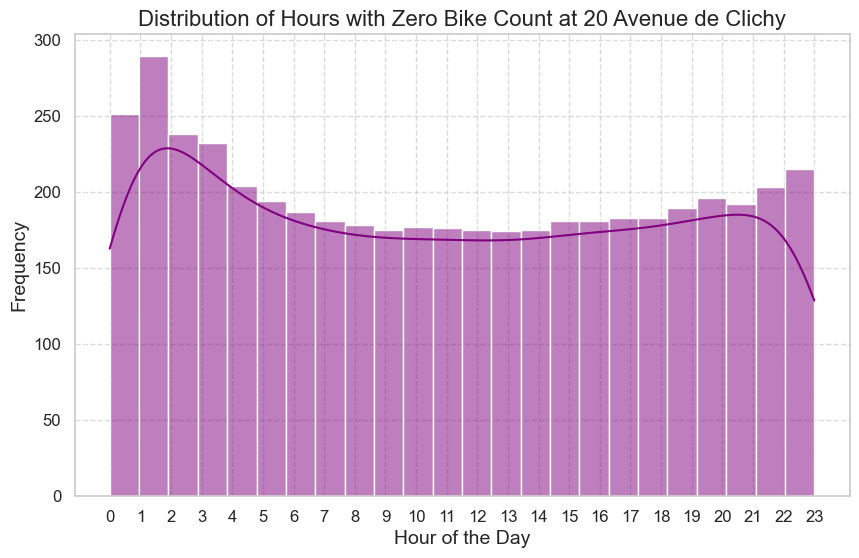

In [25]:
# Set the style
sns.set(style="whitegrid")

# Filter the data
filtered_data = train[
    (train["site_name"] == "20 Avenue de Clichy") & (train["bike_count"] == 0)
]["date"].dt.hour

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, bins=24, kde=True, color="purple")

# Add titles and labels
plt.title(
    "Distribution of Hours with Zero Bike Count at 20 Avenue de Clichy", fontsize=16
)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Customize the ticks
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()

We should try to find information about sites under repair (or else) to improve our model and make sure it predicts 0 bike_count when the site cannot capture data.

Let's check if there are changes to some variables (e.g., change in counter id) when the bike count is 0 for a prolonged period.

In [26]:
train[
    (train["date"] >= "2021-05-09")
    & (train["date"] <= "2021-07-25")
    & (train["site_name"] == "20 Avenue de Clichy")
].groupby("counter_name", observed=True).nunique()

,counter_id,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
counter_name,,,,,,,,,,,
20 Avenue de Clichy NO-SE,1,1,1,80,1849,1,1,1,1,1,80
20 Avenue de Clichy SE-NO,1,1,1,69,1849,1,1,1,1,1,69


There does not seem to be a pattern of change in any variable when the bike count is 0 for a prolonged period.

### Weather data

#### Reducing size to necessary observations

In [27]:
weather.shape

(156599, 204)

Let's start by reducing the memory usage of the weather data by selecting only observations (by date) that are relevant to the train and test set.

In [28]:
weather = weather[
    (weather["date"] >= train["date"].min() - datetime.timedelta(hours=1))
    & (weather["date"] <= test["date"].max() + datetime.timedelta(hours=1))
]

In [29]:
weather.shape

(58246, 204)

#### Weather data exploration

In [30]:
weather.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,date,RR1,QRR1,DRR1,QDRR1,...,INS,QINS,INS2,QINS2,TLAGON,QTLAGON,TVEGETAUX,QTVEGETAUX,ECOULEMENT,QECOULEMENT
5856,75106001,LUXEMBOURG,48.844667,2.333833,46,2020-09-01 00:00:00,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5857,75106001,LUXEMBOURG,48.844667,2.333833,46,2020-09-01 01:00:00,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5858,75106001,LUXEMBOURG,48.844667,2.333833,46,2020-09-01 02:00:00,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5859,75106001,LUXEMBOURG,48.844667,2.333833,46,2020-09-01 03:00:00,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5860,75106001,LUXEMBOURG,48.844667,2.333833,46,2020-09-01 04:00:00,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
weather.shape

(58246, 204)

In [32]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58246 entries, 5856 to 146061
Columns: 204 entries, NUM_POSTE to QECOULEMENT
dtypes: datetime64[ns](1), float64(200), int64(2), object(1)
memory usage: 91.1+ MB


In [33]:
weather.groupby("NUM_POSTE")["NOM_USUEL"].first()

NUM_POSTE
75106001                 LUXEMBOURG
75107005                TOUR EIFFEL
75110001               LARIBOISIERE
75114001           PARIS-MONTSOURIS
75114007    PARIS-MONTSOURIS-DOUBLE
75116008                  LONGCHAMP
Name: NOM_USUEL, dtype: object

Check the number of weather stations in the dataset.

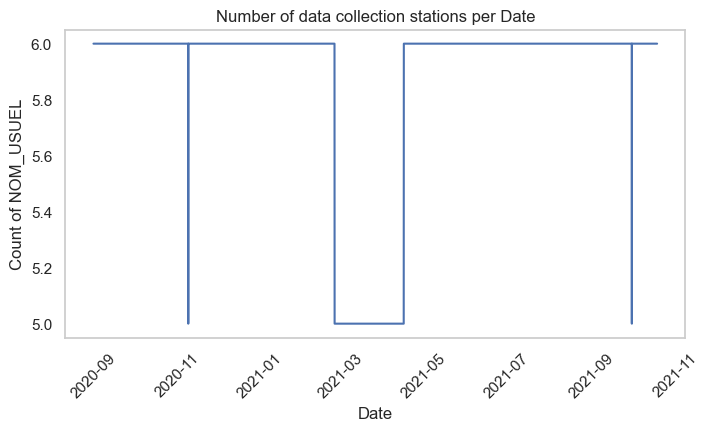

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(weather.groupby("date")["NOM_USUEL"].count(), linestyle="-")
plt.title("Number of data collection stations per Date")
plt.xlabel("Date")
plt.ylabel("Count of NOM_USUEL")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

Now, let's have a look at the location of these weather stations.

In [35]:
import folium

# Calculate the total count per location
location_counts = (
    weather.groupby(["LAT", "LON", "NUM_POSTE"]).size().reset_index(name="count")
)

# Create the map
m = folium.Map(location=weather[["LAT", "LON"]].mean(axis=0).values, zoom_start=13)

# Add markers to the map
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row["LAT"], row["LON"]],
        radius=5,
        color="black",
        fill=True,
        fill_color="black",
        fill_opacity=1,
        popup=f"NUM_POSTE: {row['NUM_POSTE']}<br>Count: {row['count']}",
    ).add_to(m)

m

In our view, there are two potential approaches to merging the weather data with the train and test sets:

* Match the weather data to the train and test sets based on the closest weather station to the coordinates.
* Match the weather data to the train and test sets using the average weather information from all collection stations in Paris.

Let's check for missing values in the weather data. We shall drop the "NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI" columns since they are categorical (or just a marker of the specific data collection station).

In [36]:
weather.drop(
    columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "date"]
).isna().sum()

RR1            18794
QRR1           18602
DRR1           48343
QDRR1          48081
FF             29941
               ...  
QTLAGON        58246
TVEGETAUX      58246
QTVEGETAUX     58246
ECOULEMENT     58246
QECOULEMENT    58246
Length: 198, dtype: int64

There seem to be fields with no values at all. We shall drop these fields and continue a more detailed on the remaining fields.

In [37]:
weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "date"]).dropna(
    axis=1, how="all"
).isna().sum()

RR1      18794
QRR1     18602
DRR1     48343
QDRR1    48081
FF       29941
         ...  
QGLO2    38462
INS      38449
QINS     38449
INS2     38463
QINS2    38463
Length: 91, dtype: int64

We just went from 198 to 91 columns.

Since there are a lot of missing values in the weather data, we will start by check if there are collection stations that have more missing values than others.

In [38]:
missing_values_per_num_poste = (
    weather.drop(columns=["NOM_USUEL", "LAT", "LON", "ALTI", "date"])
    .dropna(axis=1, how="all")
    .groupby("NUM_POSTE")
    .apply(lambda x: x.isna().sum(), include_groups=False)
)
missing_values_per_num_poste.sum(axis=1)

NUM_POSTE
75106001    763119
75107005    522358
75110001    763455
75114001     10011
75114007    782977
75116008    269829
dtype: int64

Maybe we should use the 75114001 station only, or just average out the values from all stations.

 Now, let's compute the average measure of each weather feature for each date in Paris as a whole (average out the measure over all stations at a given point in time).

In [39]:
(
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI"])
    .dropna(axis=1, how="all")
    .groupby("date")
    .mean()
    .isna()
    .sum()
    .sort_values()
)

RR1             0
QUX             0
UX              0
QHUN            0
HUN             0
             ... 
QNEIGETOT       7
QDRR1           8
DRR1            8
NEIGETOT       11
QDXI3S       9898
Length: 91, dtype: int64

"QDXI3S" seems to have many missing values. We shall exclude it from the analysis. Now, let's check the remaining fields for missing values.

In [40]:
(
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .isna()
    .sum()
    .sort_values()
    != 0
).sum()

12

There are 12 fields with missing values. We shall fill these missing values with linear interpolation since there are very few missing values. This is for sake of simplicity.

In [41]:
weather_reduced = (
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .interpolate(method="linear")
)

weather_reduced["is_rain"] = (weather_reduced["RR1"] > 0).astype(int)

#### Exploring features relationship with log_bike_count

In [42]:
weather_eda = (
    train[["date", "counter_id", "log_bike_count"]]
    .merge(weather_reduced, left_on="date", right_on="date", how="left")
    .set_index(["date", "counter_id"])
)

##### Correlation heatmap, uncovering linear relationships

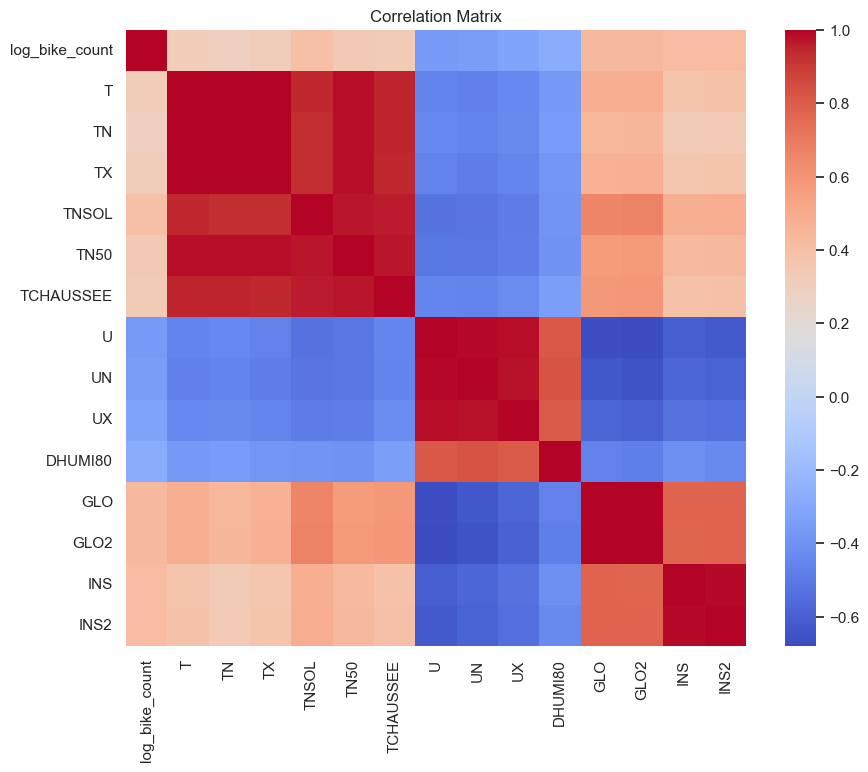

In [43]:
# Calculate the correlation matrix
correlation_matrix = weather_eda.corr()

high_corr_features = correlation_matrix[
    np.abs(correlation_matrix["log_bike_count"]) > 0.25
].index.values.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix[np.abs(correlation_matrix["log_bike_count"]) > 0.25][
        high_corr_features
    ],
    annot=False,
    cmap="coolwarm",
)

# Set the title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

##### Exploring relationships of selected features with log_bike_count

In [44]:
weather_features = ["RR1", "DRR1", "T", "TNSOL", "TCHAUSSEE", "U", "GLO", "is_rain"]

In [45]:
weather_reduced[weather_features].head()

,RR1,DRR1,T,TNSOL,TCHAUSSEE,U,GLO,is_rain
date,,,,,,,,
2020-09-01 00:00:00,0.0,0.0,12.933333,7.50,10.90,82.5,0.0,0
2020-09-01 01:00:00,0.0,0.0,12.683333,7.00,10.30,86.0,0.0,0
2020-09-01 02:00:00,0.0,0.0,12.250000,6.90,10.15,87.0,0.0,0
2020-09-01 03:00:00,0.0,0.0,12.133333,6.35,9.70,89.0,0.0,0
2020-09-01 04:00:00,0.0,0.0,11.616667,6.35,9.45,90.0,0.0,0


In [46]:
weather_reduced[weather_features].describe()

,RR1,DRR1,T,TNSOL,TCHAUSSEE,U,GLO,is_rain
count,9911.000000,9911.00000,9911.000000,9911.000000,9911.000000,9911.000000,9911.000000,9911.000000
mean,0.084862,4.93825,12.969445,11.572601,12.473994,73.153819,48.920997,0.141358
std,0.489906,14.23178,6.585028,7.857975,7.067275,15.786307,75.792628,0.348408
min,0.000000,0.00000,-5.833333,-8.050000,-3.550000,22.000000,0.000000,0.000000
25%,0.000000,0.00000,8.333333,5.925000,7.000000,62.500000,0.000000,0.000000
50%,0.000000,0.00000,12.866667,11.100000,12.100000,76.500000,1.000000,0.000000
75%,0.000000,0.00000,17.600000,16.350000,17.450000,85.500000,77.000000,0.000000
max,20.325000,60.00000,33.416667,39.250000,39.200000,97.500000,335.500000,1.000000


In [47]:
weather_eda = (
    date_encoder(train)[["date", "hour", "weekday", "counter_id", "log_bike_count"]]
    .merge(
        weather_reduced[weather_features], left_on="date", right_on="date", how="left"
    )
    .set_index(["date", "counter_id"])
)

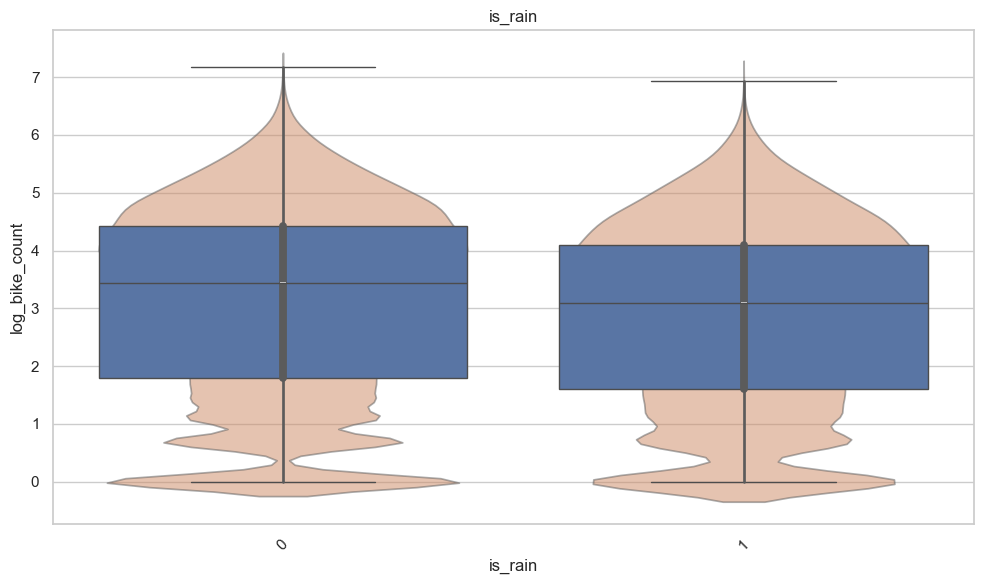

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for 'is_rain'
sns.boxplot(ax=ax, x=weather_eda["is_rain"], y=weather_eda["log_bike_count"])
plt.setp(ax.artists, alpha=0.5)
sns.violinplot(ax=ax, x=weather_eda["is_rain"], y=weather_eda["log_bike_count"])
plt.setp(ax.collections, alpha=0.5)
ax.set_title("is_rain")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

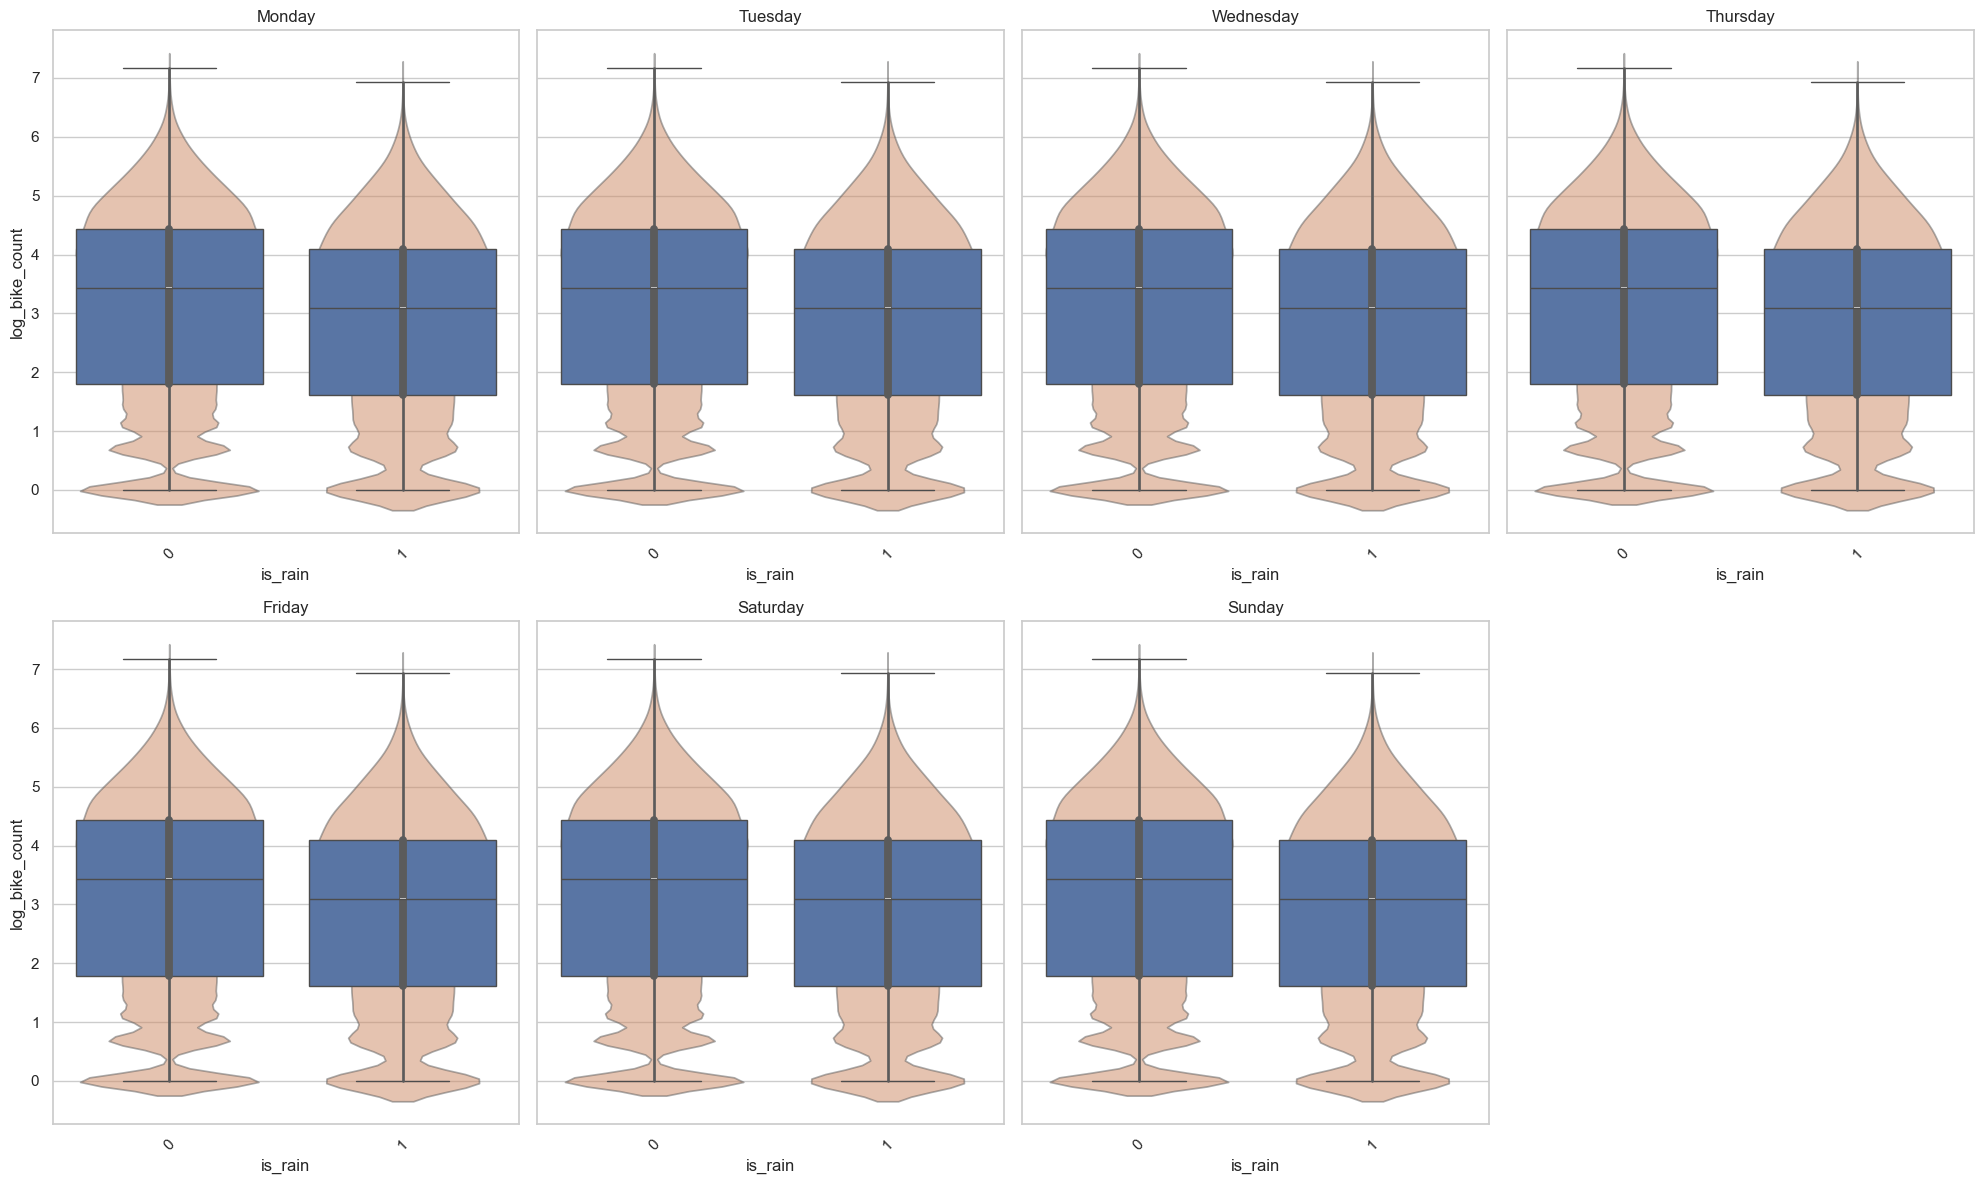

In [49]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of weekdays
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# Plot each weekday
for i, weekday in enumerate(range(1, 8)):
    ax = axes[i]
    sns.boxplot(
        ax=ax,
        x=weather_eda["is_rain"],
        y=weather_eda["log_bike_count"],
        data=weather_eda[weather_eda["weekday"] == weekday],
    )
    plt.setp(ax.artists, alpha=0.5)
    sns.violinplot(
        ax=ax,
        x=weather_eda["is_rain"],
        y=weather_eda["log_bike_count"],
        data=weather_eda[weather_eda["weekday"] == weekday],
    )
    plt.setp(ax.collections, alpha=0.5)
    ax.set_title(weekdays[i])
    ax.tick_params(axis="x", rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

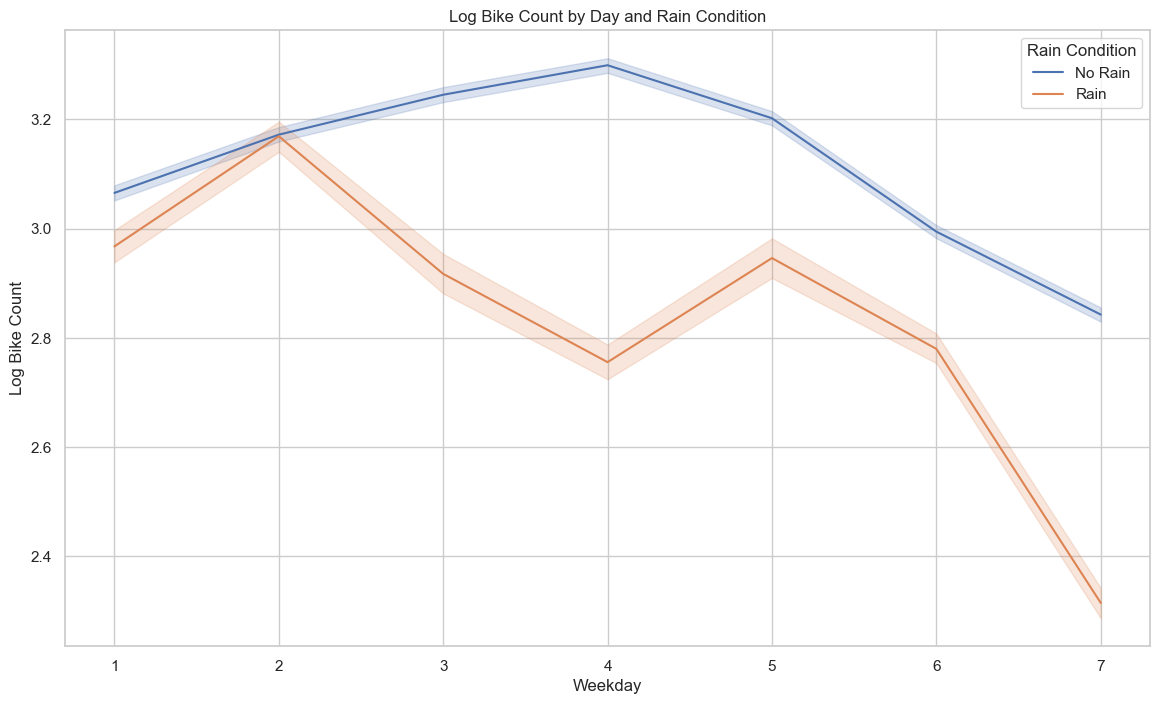

In [50]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot for is_rain = 0
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 0],
    x="weekday",
    y="log_bike_count",
    label="No Rain",
)

# Plot for is_rain = 1
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 1],
    x="weekday",
    y="log_bike_count",
    label="Rain",
)

# Add labels and title
plt.xlabel("Weekday")
plt.ylabel("Log Bike Count")
plt.title("Log Bike Count by Day and Rain Condition")
plt.legend(title="Rain Condition")

# Show the plot
plt.show()

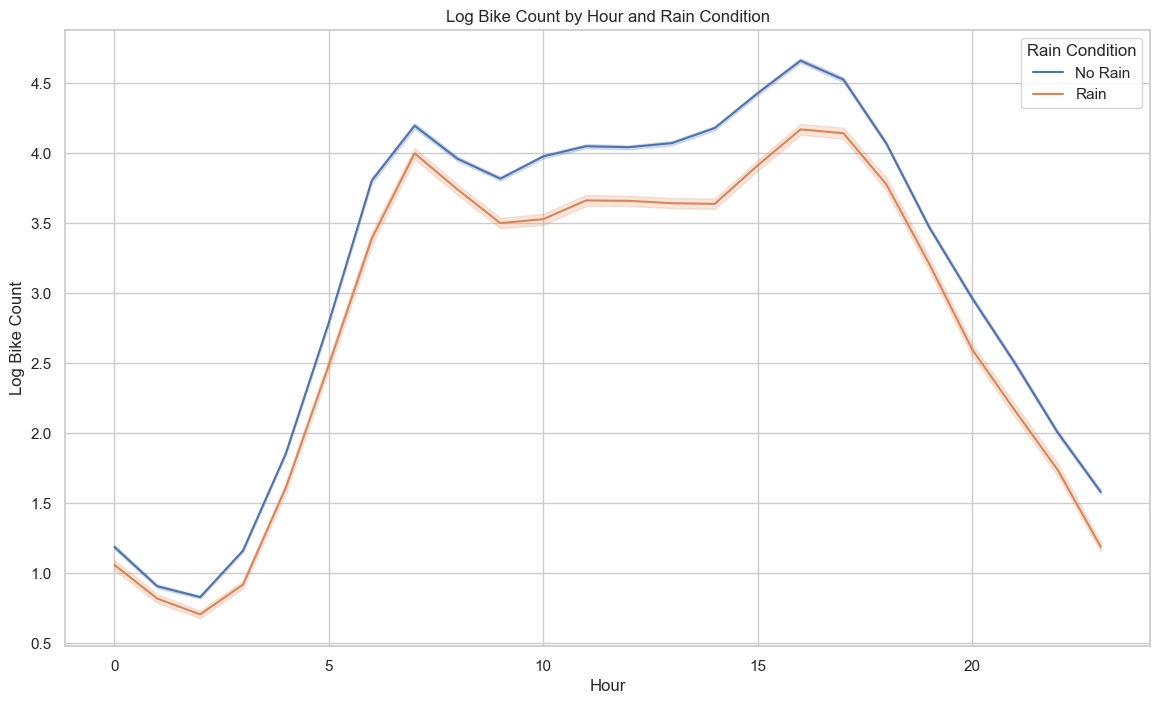

In [51]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot for is_rain = 0
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 0],
    x="hour",
    y="log_bike_count",
    label="No Rain",
)

# Plot for is_rain = 1
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 1],
    x="hour",
    y="log_bike_count",
    label="Rain",
)

# Add labels and title
plt.xlabel("Hour")
plt.ylabel("Log Bike Count")
plt.title("Log Bike Count by Hour and Rain Condition")
plt.legend(title="Rain Condition")

# Show the plot
plt.show()

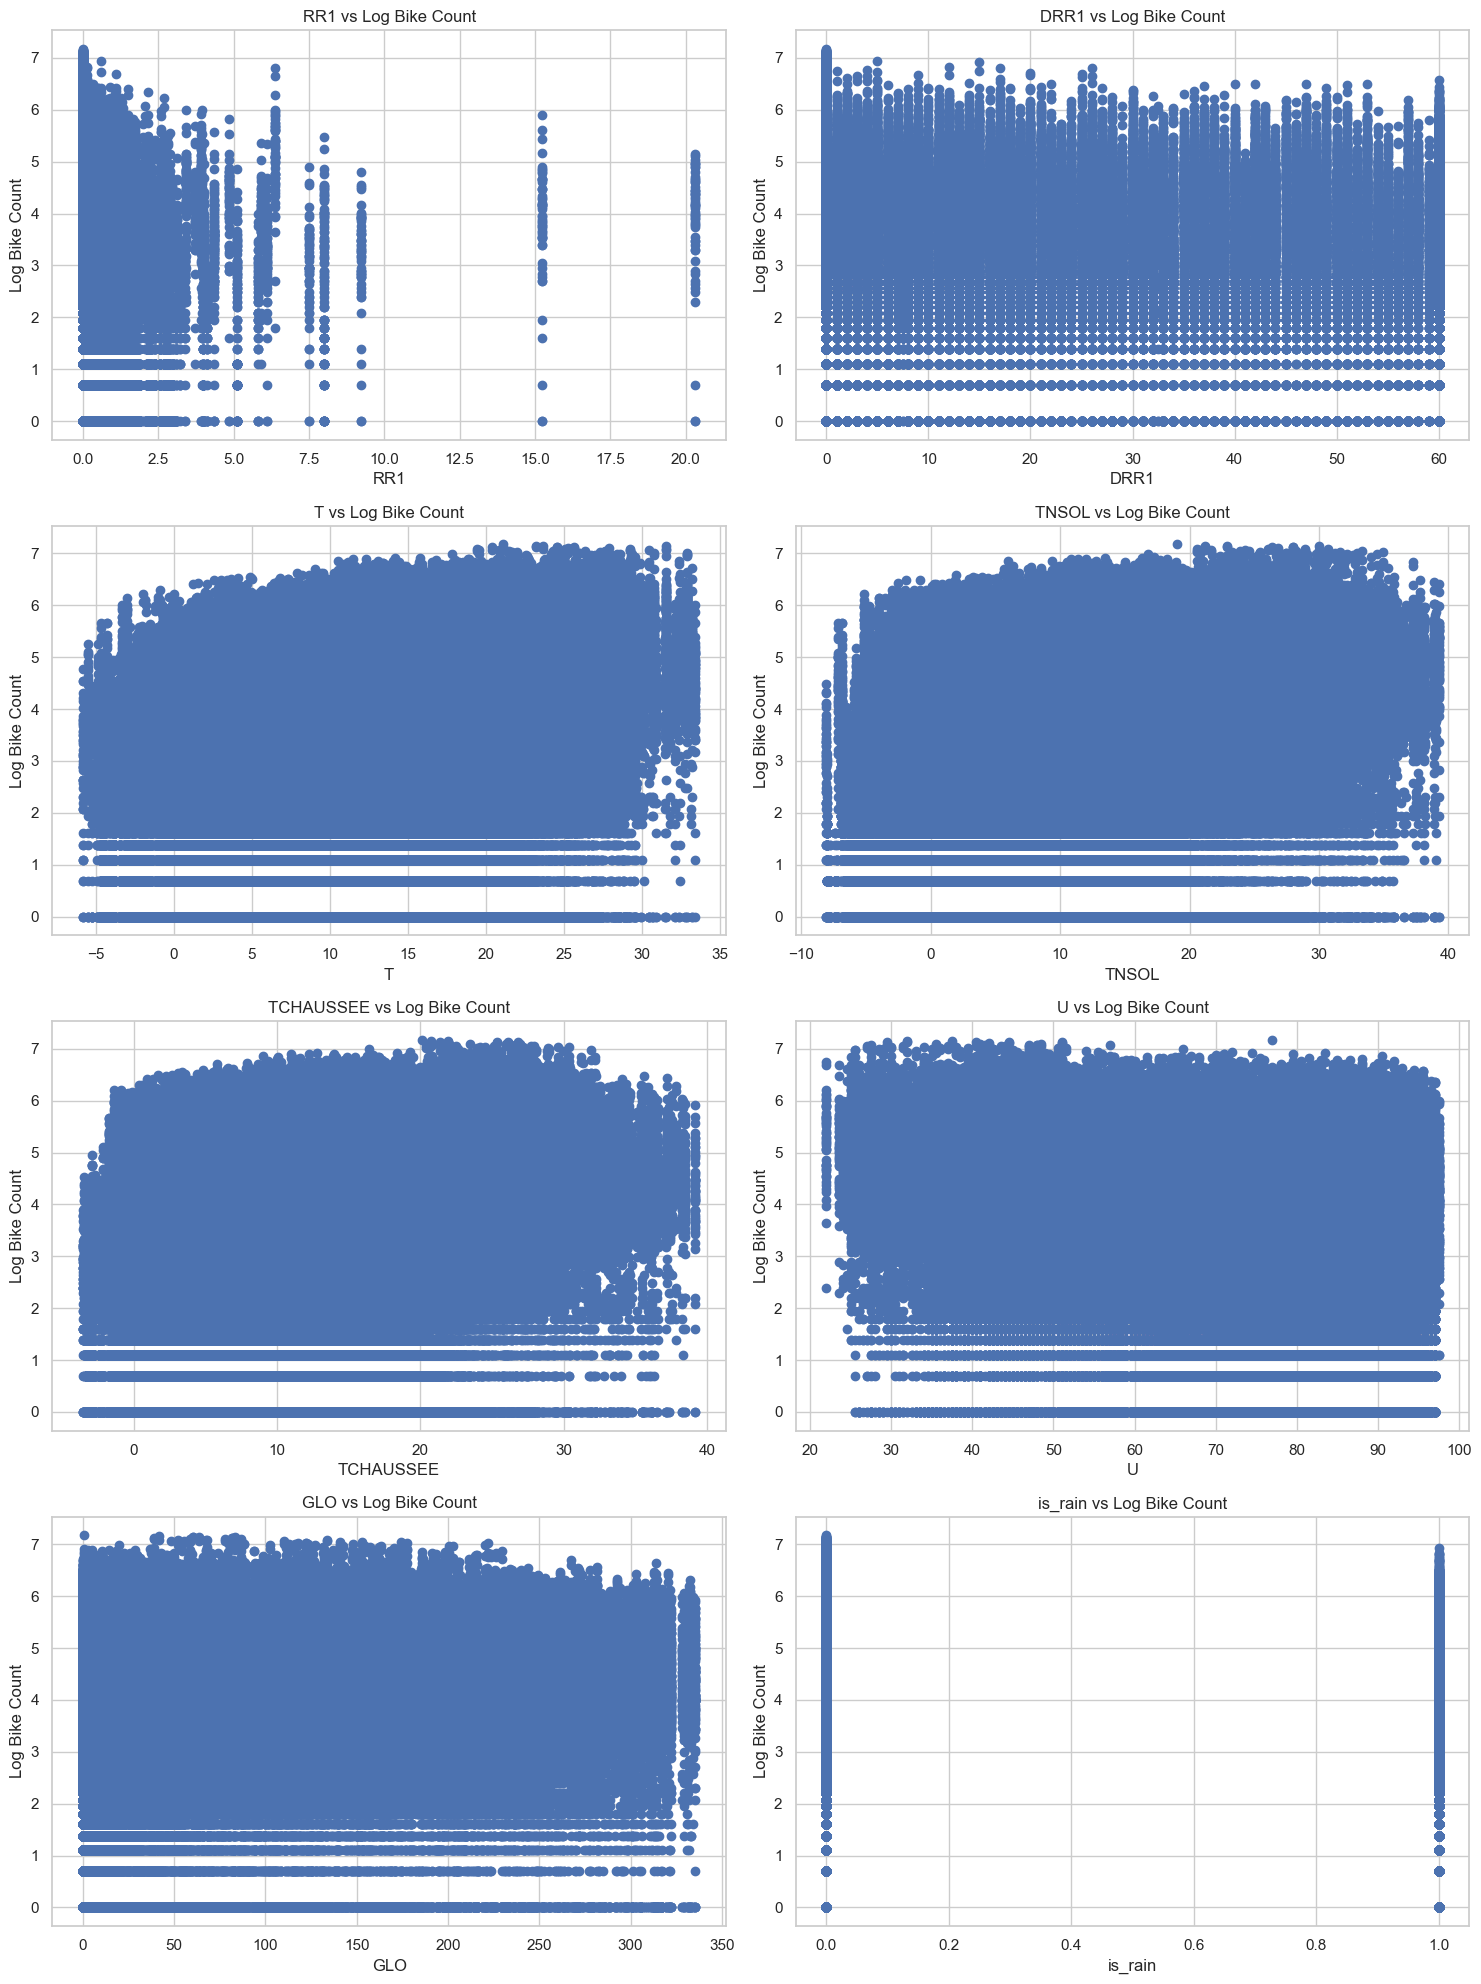

In [52]:
# Number of features
num_features = len(weather_features)

# Calculate the number of rows and columns for subplots
nrows = (num_features + 1) // 2
ncols = 2

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(weather_features):
    axes[i].scatter(weather_eda[feature], weather_eda["log_bike_count"])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Log Bike Count")
    axes[i].set_title(f"{feature} vs Log Bike Count")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

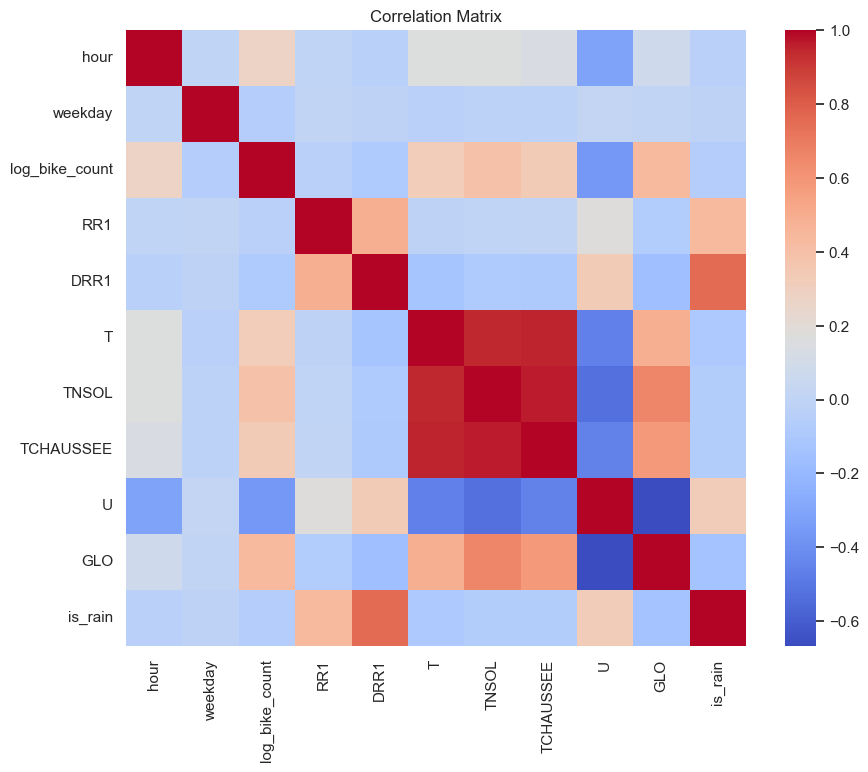

In [53]:
# Calculate the correlation matrix
correlation_matrix = weather_eda.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
)

# Set the title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

In [54]:
del weather_eda

### Public transport data

Let's compute the total number of commuters per day in Ile-de-France.

In [55]:
daily_underground_transport = underground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_underground_transport

JOUR
2020-01-01     256883
2020-01-02    1599460
2020-01-03    1788570
2020-01-04    1069824
2020-01-05     695585
               ...   
2021-12-27    3056817
2021-12-28    3310450
2021-12-29    3286128
2021-12-30    3386855
2021-12-31    2091671
Name: NB_VALD, Length: 731, dtype: int64

In [56]:
daily_overground_transport = overground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_overground_transport

JOUR
2020-01-01     403920
2020-01-02    1709413
2020-01-03    1946591
2020-01-04    1365985
2020-01-05     836146
               ...   
2021-12-27    2111105
2021-12-28    2266313
2021-12-29    2228620
2021-12-30    2306711
2021-12-31    1899306
Name: NB_VALD, Length: 731, dtype: int64

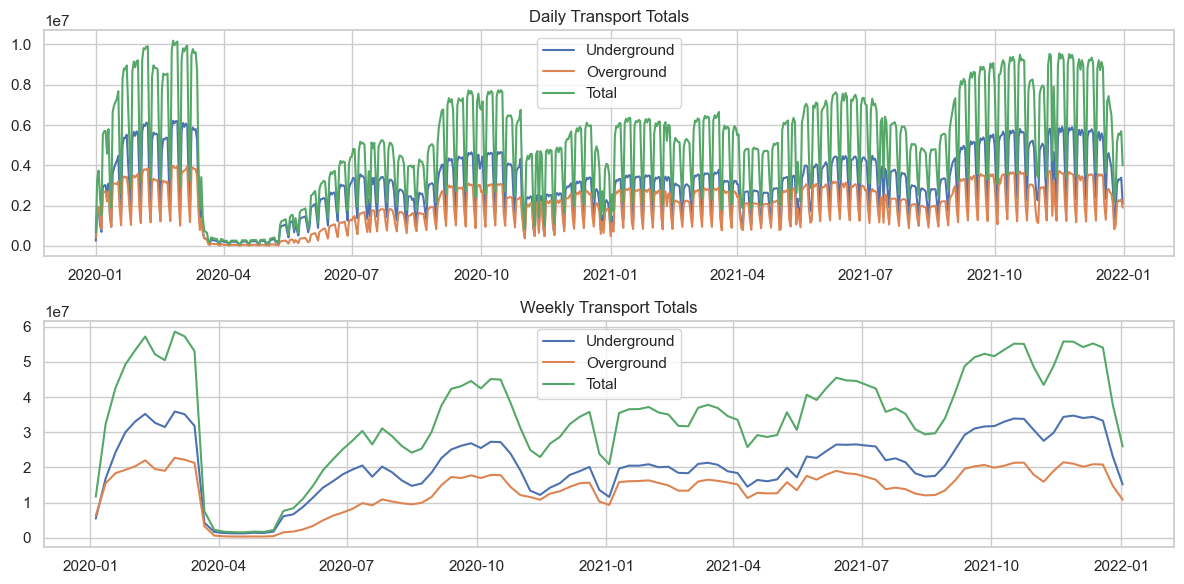

In [57]:
# Calculate daily totals
daily_underground_transport = underground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_overground_transport = overground_transport.groupby("JOUR")["NB_VALD"].sum()

# Resample to weekly totals
weekly_underground_transport = daily_underground_transport.resample("W").sum()
weekly_overground_transport = daily_overground_transport.resample("W").sum()

# Plot daily totals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(daily_underground_transport, label="Underground")
plt.plot(daily_overground_transport, label="Overground")
plt.plot(daily_underground_transport + daily_overground_transport, label="Total")
plt.legend()
plt.title("Daily Transport Totals")

# Plot weekly totals
plt.subplot(2, 1, 2)
plt.plot(weekly_underground_transport, label="Underground")
plt.plot(weekly_overground_transport, label="Overground")
plt.plot(weekly_underground_transport + weekly_overground_transport, label="Total")
plt.legend()
plt.title("Weekly Transport Totals")

plt.tight_layout()
plt.show()

Let's combine the daily number of commuters of both overground and underground transport and encode the dates to push further analysis.

In [58]:
daily_transport = (
    daily_underground_transport + daily_overground_transport
).reset_index()

daily_transport = date_encoder(daily_transport, col="JOUR")[
    (daily_transport["JOUR"] >= train["date"].min())
    & (daily_transport["JOUR"] <= test["date"].max())
]

In [59]:
daily_transport.head()

,JOUR,NB_VALD,year,quarter,month,day,weekday,hour,is_weekend,is_bank_holiday,is_school_holiday
245,2020-09-02,6332894,2020,3,9,2,3,0,0,0,0
246,2020-09-03,6728520,2020,3,9,3,4,0,0,0,0
247,2020-09-04,6770510,2020,3,9,4,5,0,0,0,0
248,2020-09-05,4106150,2020,3,9,5,6,0,1,0,0
249,2020-09-06,2579816,2020,3,9,6,7,0,1,0,0


Using this new data, we will try to detect days of strikes in the public transport system.

In [60]:
daily_transport.groupby(["month", "weekday"])["NB_VALD"].mean().unstack()

weekday,1,2,3,4,5,6,7
month,,,,,,,
1,5.894740e+06,6.186670e+06,6.073701e+06,6.251794e+06,5222307.800,3419258.40,2.093830e+06
2,5.374761e+06,5.706073e+06,5.431138e+06,5.635238e+06,5591017.750,3586681.75,2.222824e+06
3,5.898440e+06,6.214484e+06,6.099088e+06,6.289838e+06,6277103.500,3443982.00,2.143982e+06
4,3.997528e+06,4.832485e+06,4.828698e+06,4.991982e+06,4978414.400,3089901.75,1.991399e+06
5,5.590858e+06,6.468492e+06,6.490989e+06,5.734028e+06,6094340.750,3493544.60,2.496723e+06
6,7.085186e+06,7.280250e+06,7.283650e+06,7.482360e+06,7283190.750,4838024.00,3.217390e+06
7,6.100595e+06,6.407449e+06,5.598839e+06,6.510340e+06,6282567.000,4340158.60,2.936416e+06
8,4.918528e+06,5.294004e+06,5.028062e+06,5.035545e+06,4969341.000,3638042.50,2.506257e+06
9,7.652569e+06,8.083393e+06,7.574709e+06,7.877560e+06,7629104.375,4713877.00,2.980759e+06


### Other Data

# Feature engineering

## Distance to city center

In [61]:
lat_long_center = (
    train[["latitude", "longitude"]]
    - mode(
        train[train["site_name"] == "Totem 73 boulevard de Sébastopol"][
            ["latitude", "longitude"]
        ]
    )[0]
)

# We calculate the distance the previously identified site to all others
# We call the result the distance to the center since the station is close to the center of Paris
dist_center = np.linalg.norm(
    lat_long_center,
    axis=1,
)

In [62]:
print(
    f"Correlation coefficient (Distance to station with most counts VS. Log bike count): {pearsonr(dist_center, train["log_bike_count"])[0]:.3f}"
)

Correlation coefficient (Distance to station with most counts VS. Log bike count): -0.213


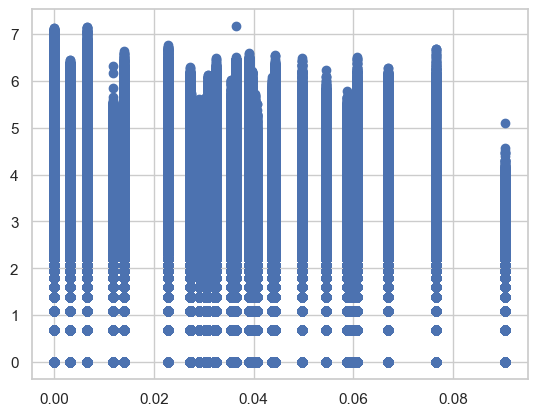

In [63]:
plt.scatter(dist_center, train["log_bike_count"])
plt.show()

In [64]:
train["distance_to_center"] = dist_center

We repeat the same process for the test set.

In [65]:
lat_long_center = (
    test[["latitude", "longitude"]]
    - mode(
        test[test["site_name"] == "Totem 73 boulevard de Sébastopol"][
            ["latitude", "longitude"]
        ]
    )[0]
)

dist_center = np.linalg.norm(
    lat_long_center,
    axis=1,
)

test["distance_to_center"] = dist_center

## Creating clusters of sites

In [66]:
# Group by counter_name and calculate the mean log_bike_count
grouped_train = (
    train.groupby("counter_name", observed=True)["log_bike_count"].mean().reset_index()
)

# Reshape the data for clustering
X = grouped_train[["log_bike_count"]]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
grouped_train["cluster"] = kmeans.fit_predict(X)

# Sort clusters by mean log_bike_count and reassign cluster labels
sorted_clusters = (
    grouped_train.groupby("cluster")["log_bike_count"].mean().sort_values().index
)
cluster_mapping = {
    old_label: new_label for new_label, old_label in enumerate(sorted_clusters)
}
grouped_train["cluster"] = grouped_train["cluster"].map(cluster_mapping)

# Merge the cluster labels back to the original DataFrame
train_1 = train.merge(
    grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
)
test_1 = test.merge(
    grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
)

## Date Encoding

In [67]:
train_1 = date_encoder(train_1, col="date")
test_1 = date_encoder(test_1, col="date")

### EDA - Analysis of new features

In [68]:
train_1.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,cluster,year,quarter,month,day,weekday,hour,is_weekend,is_bank_holiday,is_school_holiday
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,2020,3,9,1,2,2,0,0,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,2020,3,9,1,2,3,0,0,0
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,2020,3,9,1,2,4,0,0,0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,2020,3,9,1,2,15,0,0,0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,2020,3,9,1,2,18,0,0,0


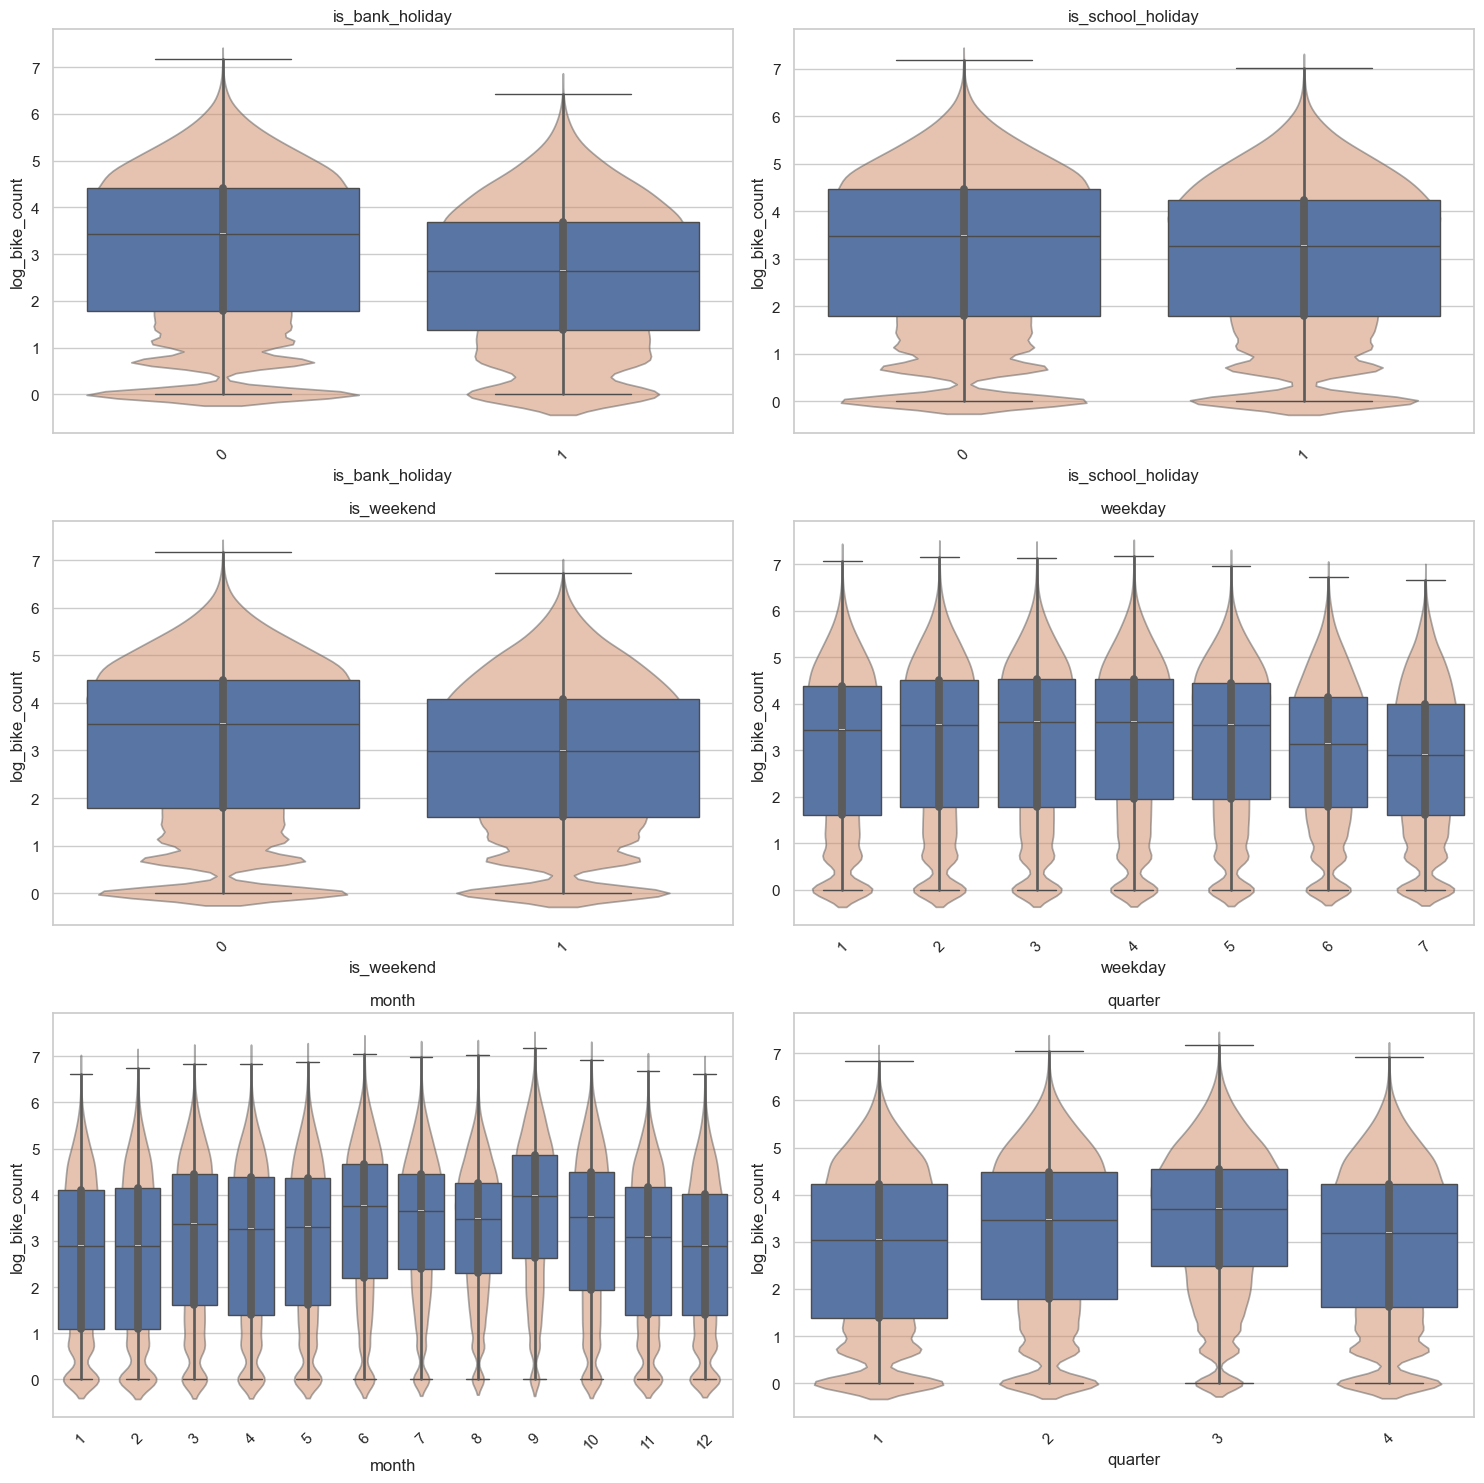

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot for 'is_bank_holiday'
sns.boxplot(ax=axes[0, 0], x=train_1["is_bank_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[0, 0], x=train_1["is_bank_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 0].collections, alpha=0.5)
axes[0, 0].set_title("is_bank_holiday")
axes[0, 0].tick_params(axis="x", rotation=45)

# Plot for 'is_school_holiday'
sns.boxplot(ax=axes[0, 1], x=train_1["is_school_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 1].artists, alpha=0.5)
sns.violinplot(
    ax=axes[0, 1], x=train_1["is_school_holiday"], y=train_1["log_bike_count"]
)
plt.setp(axes[0, 1].collections, alpha=0.5)
axes[0, 1].set_title("is_school_holiday")
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot for 'is_weekend'
sns.boxplot(ax=axes[1, 0], x=train_1["is_weekend"], y=train_1["log_bike_count"])
plt.setp(axes[1, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[1, 0], x=train_1["is_weekend"], y=train_1["log_bike_count"])
plt.setp(axes[1, 0].collections, alpha=0.5)
axes[1, 0].set_title("is_weekend")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot for 'weekday'
sns.boxplot(ax=axes[1, 1], x=train_1["weekday"], y=train_1["log_bike_count"])
plt.setp(axes[1, 1].artists, alpha=0.5)
sns.violinplot(ax=axes[1, 1], x=train_1["weekday"], y=train_1["log_bike_count"])
plt.setp(axes[1, 1].collections, alpha=0.5)
axes[1, 1].set_title("weekday")
axes[1, 1].tick_params(axis="x", rotation=45)

# Plot for 'month'
sns.boxplot(ax=axes[2, 0], x=train_1["month"], y=train_1["log_bike_count"])
plt.setp(axes[2, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[2, 0], x=train_1["month"], y=train_1["log_bike_count"])
plt.setp(axes[2, 0].collections, alpha=0.5)
axes[2, 0].set_title("month")
axes[2, 0].tick_params(axis="x", rotation=45)

# Plot for 'quarter'
sns.boxplot(ax=axes[2, 1], x=train_1["quarter"], y=train_1["log_bike_count"])
plt.setp(axes[2, 1].artists, alpha=0.5)
sns.violinplot(ax=axes[2, 1], x=train_1["quarter"], y=train_1["log_bike_count"])
plt.setp(axes[2, 1].collections, alpha=0.5)
axes[2, 1].set_title("quarter")
axes[2, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

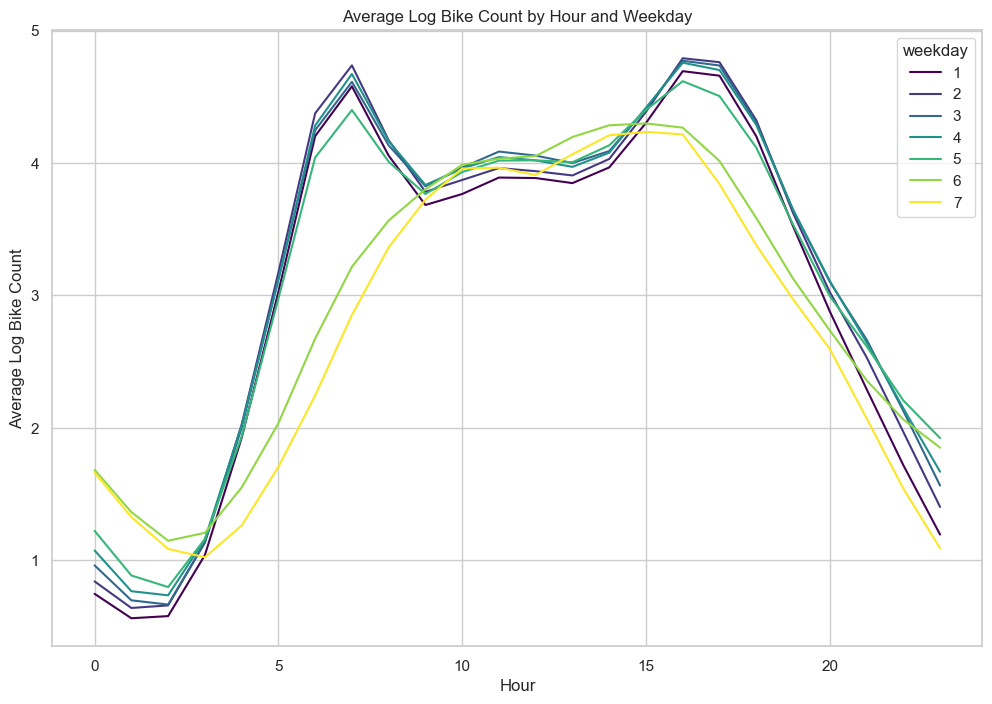

In [70]:
# Create the plot
plot = (
    train_1.groupby(["hour", "weekday"])["log_bike_count"]
    .mean()
    .unstack()
    .plot(
        figsize=(12, 8),  # Increase the figure size
        colormap="viridis",  # Use a colormap
        title="Average Log Bike Count by Hour and Weekday",  # Add a title
    )
)

# Add labels
plot.set_xlabel("Hour")
plot.set_ylabel("Average Log Bike Count")
plot.set_title("Average Log Bike Count by Hour and Weekday")

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## Removing instances of broken counters (WIP)

In [71]:
# train_2 = train_1.sort_values(["counter_id", "date"]).copy()

# # Shift of the previous bike count
# train_2["1h_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].shift(1)

# # Shift of the average bike count over the last 24 hours
# train_2["24h_avg_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].rolling(window=24).mean().shift(1).reset_index(level=0, drop=True)

# # Shift of the average bike count over the last week (7 days * 24 hours)
# train_2["1w_avg_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].rolling(window=7*24).mean().shift(1).reset_index(level=0, drop=True)

In [72]:
# train_3 = train_2[train_2["1w_avg_shift_bike_count"] != 0].drop(columns=["1h_shift_bike_count", "24h_avg_shift_bike_count", "1w_avg_shift_bike_count"])

## Adding weather data into the train and test sets

In [73]:
weather_reduced.head()

,ALTI,RR1,QRR1,DRR1,QDRR1,FF,QFF,DD,QDD,FXY,...,QNEIGETOT,GLO,QGLO,GLO2,QGLO2,INS,QINS,INS2,QINS2,is_rain
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,101.333333,0.0,1.0,0.0,9.0,2.566667,1.0,123.333333,1.0,2.766667,...,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0
2020-09-01 01:00:00,101.333333,0.0,1.0,0.0,9.0,1.900000,1.0,123.333333,1.0,2.866667,...,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0
2020-09-01 02:00:00,101.333333,0.0,1.0,0.0,9.0,1.400000,1.0,110.000000,1.0,2.033333,...,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0
2020-09-01 03:00:00,101.333333,0.0,1.0,0.0,9.0,1.100000,1.0,113.333333,1.0,1.600000,...,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0
2020-09-01 04:00:00,101.333333,0.0,1.0,0.0,9.0,1.100000,1.0,103.333333,1.0,1.366667,...,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0


### Feature handpicking from weather data

In [74]:
weather_features

['RR1', 'DRR1', 'T', 'TNSOL', 'TCHAUSSEE', 'U', 'GLO', 'is_rain']

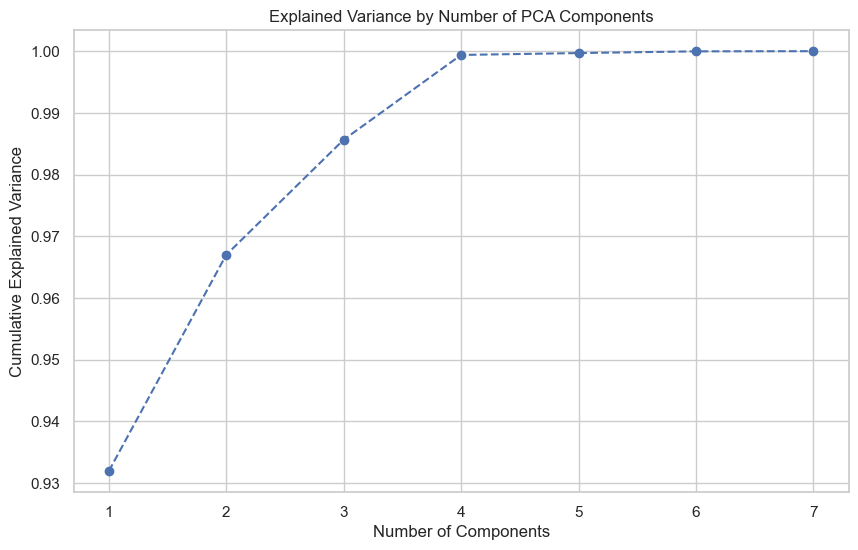

In [75]:
# Perform PCA with the maximum number of components
pca = PCA()
pca.fit(weather_reduced[weather_features[:-1]])

# Calculate the cumulative explained variance ratio
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
    color="b",
)
plt.title("Explained Variance by Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [76]:
n = 1

pca = PCA(n_components=n)

X_pca1 = pca.fit_transform(weather_reduced[weather_features[:-1]])

weather_pca = pd.DataFrame(
    X_pca1,
    index=weather_reduced[weather_features[:-1]].index,
    columns=["weather_" + str(i) for i in range(1, n + 1)],
).reset_index()

print(
    f"% of data variance explained by reduced PCA with {n} components: {pca.explained_variance_ratio_.sum():.3f}"
)

% of data variance explained by reduced PCA with 1 components: 0.932


In [77]:
weather_pca1 = weather_pca.merge(
    weather_reduced[["is_rain"]], left_on="date", right_on="date"
)

In [78]:
train_2 = train_1.merge(weather_pca1, left_on="date", right_on="date", how="left")
test_2 = test_1.merge(weather_pca1, left_on="date", right_on="date", how="left")

### PCA on weather data

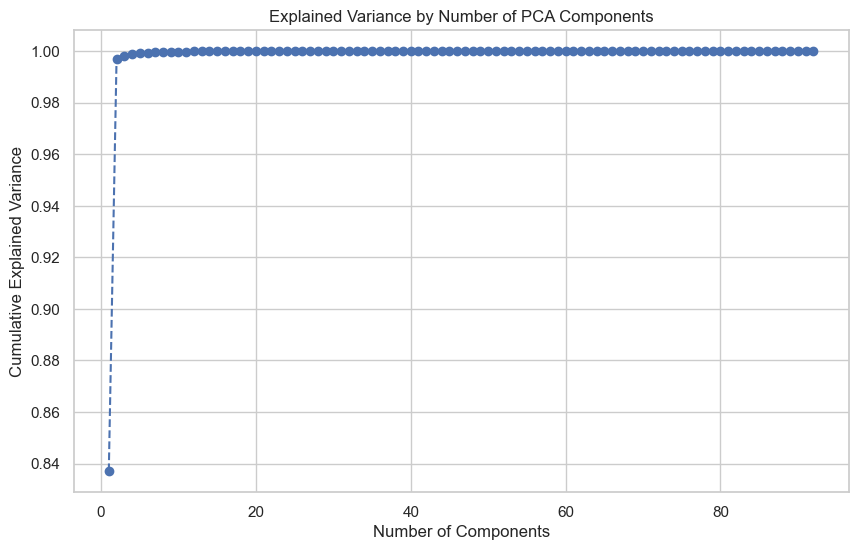

In [79]:
# Perform PCA with the maximum number of components
pca = PCA()
pca.fit(weather_reduced)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
    color="b",
)
plt.title("Explained Variance by Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [80]:
n = 5

pca = PCA(n_components=n)

X_pca1 = pca.fit_transform(weather_reduced)

weather_pca = pd.DataFrame(
    X_pca1,
    index=weather_reduced.index,
    columns=["weather_" + str(i) for i in range(1, n + 1)],
).reset_index()

print(
    f"% of data variance explained by reduced PCA with 2 components: {pca.explained_variance_ratio_.sum():.3f}"
)

% of data variance explained by reduced PCA with 2 components: 0.999


In [81]:
weather_pca.head()

,date,weather_1,weather_2,weather_3,weather_4,weather_5
0,2020-09-01 00:00:00,-2253.924793,2170.765166,93.540538,-4.059438,83.418083
1,2020-09-01 01:00:00,-1892.789018,-3177.891500,-10.029161,-99.335797,10.488174
2,2020-09-01 02:00:00,-1910.581094,-2911.985224,88.052907,-102.031552,-11.415622
3,2020-09-01 03:00:00,-1928.948872,-2638.106052,107.643143,-104.300352,-14.508872
4,2020-09-01 04:00:00,-1947.856004,-2357.575323,119.987810,-102.552917,-37.015761


In [82]:
# weather_pca["weather_interaction"] = (weather_pca["weather_1"] * weather_pca["weather_2"]) ** 2

# for i in range(1, n + 1):
#     weather_pca[f"weather_{i}_1hlag"] = weather_pca[f"weather_{i}"].shift(1)

# weather_pca.dropna(inplace=True)

In [83]:
weather_pca.head()

,date,weather_1,weather_2,weather_3,weather_4,weather_5
0,2020-09-01 00:00:00,-2253.924793,2170.765166,93.540538,-4.059438,83.418083
1,2020-09-01 01:00:00,-1892.789018,-3177.891500,-10.029161,-99.335797,10.488174
2,2020-09-01 02:00:00,-1910.581094,-2911.985224,88.052907,-102.031552,-11.415622
3,2020-09-01 03:00:00,-1928.948872,-2638.106052,107.643143,-104.300352,-14.508872
4,2020-09-01 04:00:00,-1947.856004,-2357.575323,119.987810,-102.552917,-37.015761


In [84]:
train_2 = train_1.merge(weather_pca, left_on="date", right_on="date", how="left")
test_2 = test_1.merge(weather_pca, left_on="date", right_on="date", how="left")

In [85]:
# plt.scatter(train_2[train_2["is_weekend"] == 0]["weather_1_1hlag"], train_2[train_2["is_weekend"] == 0]["log_bike_count"])
# plt.scatter(train_2[train_2["is_weekend"] == 1]["weather_1_1hlag"], train_2[train_2["is_weekend"] == 1]["log_bike_count"])
# plt.show()

In [86]:
# for i in range(1, n + 1):
#     plt.scatter((train_2[f"weather_{i}"]), train_2["log_bike_count"])

# plt.show()

# Adding construction sites

In [243]:
#https://opendata.paris.fr/explore/dataset/chantiers-a-paris-copie0/information/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
construction_sites_2020 = pd.read_parquet("/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/chantiers-a-paris-2020.parquet")

#https://opendata.paris.fr/explore/embed/dataset/chantiers-a-paris-copie1/table/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
construction_sites_2021 = pd.read_parquet("/Users/apple/Desktop/Cours Polytechnique/Python for DS/Kaggle compétition/external_data/chantiers-a-paris-2021.parquet")

In [244]:
construction_sites_2020.head()

,num_emprise,cp_arrondissement,date_debut,date_fin,chantier_categorie,moa_principal,surface,chantier_synthese,localisation_detail,localisation_stationnement,demande_cite_id,chantier_cite_id,geo_shape,geo_point_2d
0,EC184638,75020,2020-09-21,2020-10-20,Opérateurs de réseau (gaz-électricité-RATP-etc),ORANGE,49.39,Travaux sur réseau télécom,EMPRISE_TROTTOIR,None,253413,126431,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x15\x83.\xeb\x14-\x03@\...
1,EC184663,75009,2020-09-14,2020-10-09,Ville de Paris (Tvx sur espace ou édifice public),Direction de la Voirie et des Déplacements,18.49,Aménagement de voirie (VdP*),EMPRISE_CHAUSSEE,None,253732,126441,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x04\xac\xe2\xd36\xa3\x0...
2,EC184760,75005,2020-09-07,2020-11-06,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,9.49,Construction ou réhabilitation d'immeuble,EMPRISE_CHAUSSEE,STATIONNEMENT_PAYANT,253851,126477,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00se\x15\xf1\xeb\xd0\x02@\...
3,EC184790,75012,2020-10-12,2020-11-13,Opérateurs de réseau (gaz-électricité-RATP-etc),ENEDIS,3.09,Travaux sur réseau électrique,EMPRISE_TROTTOIR,None,254001,126524,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...",b'\x01\x01\x00\x00\x00x\x82\x9e\x14\x96\x05\x0...
4,EC184837,75004,2020-10-19,2020-10-28,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,4.45,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,254059,126550,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\r\xaaf\x0f\xfb\xe1\x02@...


In [246]:
construction_sites_2021.head()

,num_emprise,cp_arrondissement,date_debut,date_fin,chantier_categorie,moa_principal,surface,chantier_synthese,localisation_detail,localisation_stationnement,demande_cite_id,chantier_cite_id,geo_shape,geo_point_2d
0,EC203464,75011,2021-01-18,2021-02-02,Opérateurs de réseau (gaz-électricité-RATP-etc),ENEDIS,4.05,Travaux sur réseau électrique,EMPRISE_TROTTOIR,None,320726,138432,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00l\x9a\xa6\xaeH\x03\x03@\...
1,EC203501,75015,2021-01-13,2021-03-04,Opérateurs de réseau (gaz-électricité-RATP-etc),ENEDIS,3.04,Travaux sur réseau électrique,EMPRISE_TROTTOIR,None,320828,138470,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00FZ[\xfc\x95i\x02@\x9d\xe...
2,EC203552,75007,2021-01-18,2021-02-19,Ville de Paris (Tvx sur espace ou édifice public),Section de l'Assainissement de Paris,23.04,Travaux sur réseau d'assainissement (VdP*),EMPRISE_TROTTOIR,STATIONNEMENT_PAYANT,321139,138504,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\xa0\x9d\xc6\x85\xd6\x94...
3,EC203579,75004,2021-02-07,2021-02-07,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,22.32,Construction ou réhabilitation d'immeuble,EMPRISE_CHAUSSEE,STATIONNEMENT_PAYANT,321388,138532,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...",b'\x01\x01\x00\x00\x00\x1fI\x17\xb8\xa7\xd9\x0...
4,EC203639,75010,2021-03-22,2021-04-23,Opérateurs de réseau (gaz-électricité-RATP-etc),GRDF,1.08,Travaux sur réseau de gaz,EMPRISE_TROTTOIR,None,322074,138586,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...",b'\x01\x01\x00\x00\x00\xd2\xf0\x031\x85\xee\x0...


In [248]:
construction_sites = pd.concat([construction_sites_2020, construction_sites_2021], axis=0)

In [249]:
construction_sites

,num_emprise,cp_arrondissement,date_debut,date_fin,chantier_categorie,moa_principal,surface,chantier_synthese,localisation_detail,localisation_stationnement,demande_cite_id,chantier_cite_id,geo_shape,geo_point_2d
0,EC184638,75020,2020-09-21,2020-10-20,Opérateurs de réseau (gaz-électricité-RATP-etc),ORANGE,49.39,Travaux sur réseau télécom,EMPRISE_TROTTOIR,None,253413,126431,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x15\x83.\xeb\x14-\x03@\...
1,EC184663,75009,2020-09-14,2020-10-09,Ville de Paris (Tvx sur espace ou édifice public),Direction de la Voirie et des Déplacements,18.49,Aménagement de voirie (VdP*),EMPRISE_CHAUSSEE,None,253732,126441,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x04\xac\xe2\xd36\xa3\x0...
2,EC184760,75005,2020-09-07,2020-11-06,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,9.49,Construction ou réhabilitation d'immeuble,EMPRISE_CHAUSSEE,STATIONNEMENT_PAYANT,253851,126477,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00se\x15\xf1\xeb\xd0\x02@\...
3,EC184790,75012,2020-10-12,2020-11-13,Opérateurs de réseau (gaz-électricité-RATP-etc),ENEDIS,3.09,Travaux sur réseau électrique,EMPRISE_TROTTOIR,None,254001,126524,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...",b'\x01\x01\x00\x00\x00x\x82\x9e\x14\x96\x05\x0...
4,EC184837,75004,2020-10-19,2020-10-28,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,4.45,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,254059,126550,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\r\xaaf\x0f\xfb\xe1\x02@...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32680,EC233928,75011,2021-07-05,2021-07-23,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,0.03,Construction ou réhabilitation d'immeuble,EMPRISE_TROTTOIR,None,431141,157552,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,b'\x01\x01\x00\x00\x00_[\x7f\xb0\x91%\x03@\xe9...
32681,EC237573,75001,2021-08-01,2021-08-08,Tiers (travaux sur bâtiment),Propriétés - Co-propriétés publiques et privées,302.21,Construction ou réhabilitation d'immeuble,"EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",None,443860,159858,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,b'\x01\x01\x00\x00\x00\xb0:8B\xa1\xa1\x02@\xed...
32682,EC240762,75010,2021-08-25,2022-04-20,Opérateurs de réseau (gaz-électricité-RATP-etc),EAU DE PARIS,65.57,Travaux sur réseau d'eau,"EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",None,460530,161977,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,b'\x01\x01\x00\x00\x00[\xb8%8y\xf0\x02@\xa8\x8...
32683,EC252856,75012,2021-11-24,2021-11-26,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,10.81,Travaux sur réseau de transport public,EMPRISE_CHAUSSEE,None,512246,169443,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,b'\x01\x01\x00\x00\x00\x11\xd3\x12\x1e\xcb\t\x...


### deleting the constructions that appear twice as they extend over 2020 and 2021 (keeping only the longest)

In [250]:
# Identify duplicates: Keep only the second occurrence of duplicates
mask_second = construction_sites.duplicated(subset=['num_emprise'], keep='first')

# Identify unique rows (no duplicates at all)
mask_unique = ~construction_sites.duplicated(subset=['num_emprise'], keep=False)

# Combine the two conditions: Keep rows that are either unique or second occurrences
final_mask = mask_second | mask_unique

# Apply the mask to filter the DataFrame
construction_sites = construction_sites[final_mask]

print(construction_sites)

      num_emprise cp_arrondissement  date_debut    date_fin  \
0        EC184638             75020  2020-09-21  2020-10-20   
1        EC184663             75009  2020-09-14  2020-10-09   
2        EC184760             75005  2020-09-07  2020-11-06   
3        EC184790             75012  2020-10-12  2020-11-13   
4        EC184837             75004  2020-10-19  2020-10-28   
...           ...               ...         ...         ...   
32680    EC233928             75011  2021-07-05  2021-07-23   
32681    EC237573             75001  2021-08-01  2021-08-08   
32682    EC240762             75010  2021-08-25  2022-04-20   
32683    EC252856             75012  2021-11-24  2021-11-26   
32684    EC103441             75004  2019-07-08  2021-03-26   

                                      chantier_categorie  \
0        Opérateurs de réseau (gaz-électricité-RATP-etc)   
1      Ville de Paris (Tvx sur espace ou édifice public)   
2                           Tiers (travaux sur bâtiment)   
3  

In [251]:
has_duplicates = construction_sites['num_emprise'].duplicated(keep=False).any()
print(f"Are there duplicates? {has_duplicates}")

Are there duplicates? False


In [252]:
num_duplicates = construction_sites['num_emprise'].duplicated(keep=False).sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Simplyfing the dataset

In [254]:
construction_sites['localisation_detail'].unique()

array(['EMPRISE_TROTTOIR', 'EMPRISE_CHAUSSEE',
       'EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR',
       'EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR',
       'EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR',
       'EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE', None,
       'EMPRISE_CHAUSSEE,EMPRISE_CHAUSSEE'], dtype=object)

J'enlève les travaux qui ne bloque pas les pistes cyclables

In [255]:
construction_sites_simplified = construction_sites[~construction_sites['localisation_detail'].isin(['EMPRISE_CHAUSSEE','EMPRISE_TROTTOIR', 
                                        'EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR',None])]
                                        

construction_sites_simplified['localisation_detail'].unique()

array(['EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR',
       'EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR',
       'EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE',
       'EMPRISE_CHAUSSEE,EMPRISE_CHAUSSEE'], dtype=object)

Je drop les collonnes inutiles

In [256]:
construction_sites_simplified.drop(columns=['moa_principal', 'demande_cite_id', 'chantier_synthese', 'localisation_stationnement', 'chantier_cite_id', 'chantier_categorie', 'cp_arrondissement', 'num_emprise'], inplace=True)
construction_sites_simplified.head()

/var/folders/jd/_41jr63j245210xpt44m7yjh0000gn/T/ipykernel_10257/3327606103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  construction_sites_simplified.drop(columns=['moa_principal', 'demande_cite_id', 'chantier_synthese', 'localisation_stationnement', 'chantier_cite_id', 'chantier_categorie', 'cp_arrondissement', 'num_emprise'], inplace=True)


,date_debut,date_fin,surface,localisation_detail,geo_shape,geo_point_2d
22,2020-08-28,2020-09-23,5.33,"EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x19\xb8\xcb\x0c\xbd\xeb...
195,2020-08-03,2020-08-17,405.02,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00...,b'\x01\x01\x00\x00\x00\xa7\tW\x9aR\xe8\x02@\x9...
218,2020-08-10,2020-08-13,156.51,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00_9\xda<\x8c\xc1\x02@\xa8...
346,2020-11-30,2020-12-18,13483.08,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\xb1\x0b-\xca\xa7E\x02@\...
379,2019-02-28,2020-04-30,59.74,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x06\x00...,b'\x01\x01\x00\x00\x00\xe1\xa4\xb0\xf5\xa9\x90...


In [257]:
construction_sites_simplified.head()

,date_debut,date_fin,surface,localisation_detail,geo_shape,geo_point_2d
22,2020-08-28,2020-09-23,5.33,"EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\x19\xb8\xcb\x0c\xbd\xeb...
195,2020-08-03,2020-08-17,405.02,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00...,b'\x01\x01\x00\x00\x00\xa7\tW\x9aR\xe8\x02@\x9...
218,2020-08-10,2020-08-13,156.51,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00_9\xda<\x8c\xc1\x02@\xa8...
346,2020-11-30,2020-12-18,13483.08,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00\xb1\x0b-\xca\xa7E\x02@\...
379,2019-02-28,2020-04-30,59.74,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x06\x00...,b'\x01\x01\x00\x00\x00\xe1\xa4\xb0\xf5\xa9\x90...


### trying to convert geo_points into coordinates in order to merge with train_1 dataset

In [258]:
from shapely import wkb

#### Test with one row

In [259]:
geo_point_wkb = b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xe9S6&\xfe\xd0\x02@\x11n\xdck\x04lH@M\r\xfc\xba\xfb\xd0\x02@\xc9R\x7f\xda\x03lH@\x9b\xae\xfb\xe5\xd8\xd0\x02@q\xb4\xd0d\x04lH@\x01E\x7f\r\xdc\xd0\x02@\x81\x1f\xf7\xe6\x04lH@\xe9S6&\xfe\xd0\x02@\x11n\xdck\x04lH@'
geometry = wkb.loads(geo_point_wkb)
print(geometry)

POLYGON ((2.3520472512559434 48.843884928352175, 2.3520426376505044 48.843867599649066, 2.351976200812556 48.843884088427224, 2.351982217260798 48.84389960352474, 2.3520472512559434 48.843884928352175))


Visualisation

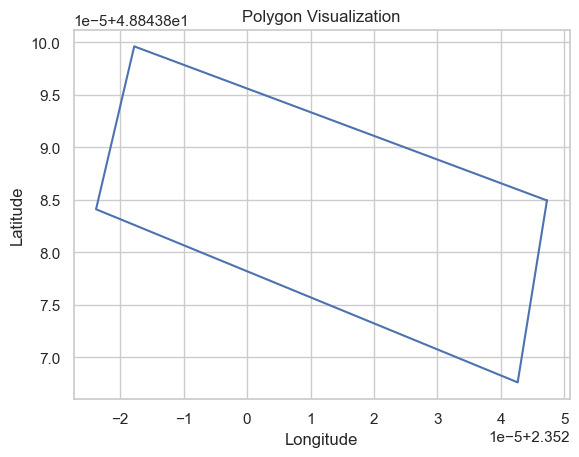

In [260]:
from shapely.wkt import loads
import matplotlib.pyplot as plt

# Convert WKT to a geometry object
polygon = loads("POLYGON ((2.3520472512559434 48.843884928352175, 2.3520426376505044 48.843867599649066, 2.351976200812556 48.843884088427224, 2.351982217260798 48.84389960352474, 2.3520472512559434 48.843884928352175))")

# Extract x and y coordinates for plotting
x, y = polygon.exterior.xy

# Plot the polygon
plt.plot(x, y)
plt.title("Polygon Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Transforming all geo_shape into coordinate

In [261]:
def decode_wkb_to_coordinates(wkb_data):
    try:
        geometry = wkb.loads(wkb_data)  # Decode WKB to a geometry object
        if geometry.geom_type == 'Polygon':  # Handle polygons
            return list(geometry.exterior.coords)
        elif geometry.geom_type == 'Point':  # Handle points
            return list(geometry.coords)
        elif geometry.geom_type == 'LineString':  # Handle lines
            return list(geometry.coords)
        else:
            return None  # For unsupported geometry types
    except Exception as e:
        print(f"Error decoding WKB: {e}")
        return None

In [263]:
construction_sites_coordinates = construction_sites_simplified.copy()
construction_sites_coordinates['coordinates'] = construction_sites_coordinates['geo_shape'].apply(decode_wkb_to_coordinates)
construction_sites_coordinates.drop(columns=['geo_shape'], inplace=True)
construction_sites_coordinates.head()




Error decoding WKB: 'NoneType' object has no attribute 'geom_type'


,date_debut,date_fin,surface,localisation_detail,geo_point_2d,coordinates
22,2020-08-28,2020-09-23,5.33,"EMPRISE_PISTE_CYCLABLE,EMPRISE_TROTTOIR",b'\x01\x01\x00\x00\x00\x19\xb8\xcb\x0c\xbd\xeb...,"[(2.3651055570484045, 48.87218852148543), (2.3..."
195,2020-08-03,2020-08-17,405.02,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x01\x00\x00\x00\xa7\tW\x9aR\xe8\x02@\x9...,"[(2.3636221067688026, 48.841960728932875), (2...."
218,2020-08-10,2020-08-13,156.51,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x01\x00\x00\x00_9\xda<\x8c\xc1\x02@\xa8...,"[(2.344602971418473, 48.85957677678064), (2.34..."
346,2020-11-30,2020-12-18,13483.08,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE",b'\x01\x01\x00\x00\x00\xb1\x0b-\xca\xa7E\x02@\...,"[(2.288430088719194, 48.873186654106746), (2.2..."
379,2019-02-28,2020-04-30,59.74,"EMPRISE_CHAUSSEE,EMPRISE_PISTE_CYCLABLE,EMPRIS...",b'\x01\x01\x00\x00\x00\xe1\xa4\xb0\xf5\xa9\x90...,"[(2.320682379475191, 48.88901471612273), (2.32..."


### Date Encoding pour les chantiers

In [264]:
## TODO ??

## Feature encoding

In [88]:
# preprocessor = ColumnTransformer()

# Testing

In [89]:
# X_train = train_2.drop(columns=["bike_count", "log_bike_count", "date"])
# y_train = train_2["log_bike_count"]

# X_test = test_2.drop(columns=["date"])

# model = xgb.XGBRegressor(random_state=42)

# pipe = Pipeline(
#     steps=[
#         ("preprocessor", TableVectorizer()),
#         ("regressor", model),
#     ]
# )

## Finetuning

In [90]:
# from sklearn.model_selection import TimeSeriesSplit

# cv = TimeSeriesSplit(n_splits=3)

# # When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
# scores = cross_val_score(
#     pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
# )
# print("RMSE: ", scores)
# print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

## Output

In [91]:
# X_test.head()

In [92]:
# pipe.fit(X_train, y_train)
# y_test = pipe.predict(X_test)

In [93]:
# pd.DataFrame(y_test, columns=["log_bike_count"]).reset_index().rename(
#     columns={"index": "Id"}
# ).to_csv("/Users/pierrehaas/bike_counters/predictions.csv", index=False)

In [94]:
# pd.DataFrame(y_test, columns=["log_bike_count"]).reset_index().rename(
#     columns={"index": "Id"}
# )

In [95]:
# pipe.named_steps["preprocessor"]

# Poubelle